<h1 align="center">Supplementary information for<a class="tocSkip"></h1>
<h1 align="center">Hydrous Silicate Melts and the Transition-Zone Water Filter<a class="tocSkip"></h1>

<h3 align="center">James W. E. Drewitt<sup>a</sup>, Michael J. Walter<sup>b</sup>, John P. Brodholt<sup>c</sup>, Joshua M. R. Muir<sup>d</sup>, and Oliver T. Lord<sup>a</sup><a class="tocSkip"></h3>

<h4 align="center"><sup>a</sup> School of Earth Sciences, University of Bristol, Wills Memorial Building, Queens Road, BS8 1RJ, United Kingdom<a class="tocSkip"></h4>

<h4 align="center"><sup>b</sup> Geophysical Laboratory, Carnegie Institution for Science, 5251 Broad Branch Road NW, Washington D.C. 20015, USA<a class="tocSkip"></h4>

<h4 align="center"><sup>c</sup> Department of Earth Sciences, University College London, Gower Street, London, WC1E 6BT, UK<a class="tocSkip"></h4>

<h4 align="center"><sup>d</sup> University of Leeds, School of Earth and Environment, Leeds, LS2 9JT<a class="tocSkip"></h4>
    
<h3 align="center">Jupyter Notebook Written by <a href="mailto:oliver.lord@bristol.ac.uk">Oliver T Lord</a>, <a href="http://www.bristol.ac.uk/earthsciences/people/person/oliver-t-lord/overview.html">(School of Earth Sciences, University of Bristol)<a class="tocSkip"></h3>

<br />

Copyright 2020 Oliver Lord.

This notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

A copy of the GNU General Public License can be found in the associated GitHub repository. If not, see <http://www.gnu.org/licenses/>.

<h3 align="left">Dependencies:<a class="tocSkip"></h3>



Tables are presented using a combination of the <a href="https://pypi.org/project/pandas/">Pandas</a> and <a href="https://pypi.org/project/itables/">iTables</a> libraries.

Ternary plots are prodcued using the <a href="https://pypi.org/project/mpltern/">mpltern</a> library, an extension of <a href="https://matplotlib.org/">Matplotlib</a>.

Fitting is performed using the orthogonal distance regression method based on the ODRPACK Fortran library<sup>1</sup> as implimented in <a href="https://www.scipy.org/">Scipy</a>. At each compositional point, pressures are calculated using the Mie-Grueneisen-Debye thermal Equation of State as implemented in the <a href="https://pypi.org/project/burnman/">Burnman</a> thermodynamics toolkit<sup>2</sup>. More information on Burnman and its developers can be found <a href="https://burnman.org/">here</a>.

Interactive ocontrol widgets are provided through the <a href="https://pypi.org/project/ipywidgets/">ipywidget</a> library.

In addition to those mentioned above, this notebook also requires the <a href="https://pypi.org/project/numpy/">Numpy</a>, <a href="https://docs.python.org/3/library/itertools.html">itertools</a>, <a href="https://pypi.org/project/ipython/">IPython</a> and <a href="https://pypi.org/project/tqdm/">tqdm</a> libraries.

Finally, this notebook is made available to anyone, anywhere, in an immediately executable form, from its <a href="https://github.com/olivertlord/hydrous-melts">Github repository</a> via the <a href="https://mybinder.org/v2/gh/olivertlord/hydrous-melts/main?urlpath=apps%2Fhydrous_melt_PVTX.ipynb">Binder</a> service.

___

<sup>1</sup>Zwolak, J. W., Boggs, P. T. & Watson, L. T. Algorithm 869: ODRPACK95: A weighted orthogonal distance regression code with bound constraints. Acm Transactions Math Softw Toms 33, 27 (2007).
  
<sup>2</sup>Cottaar, S., Heister, T., Rose, I. & Unterborn, C. BurnMan: A lower mantle mineral physics toolkit. Geochemistry, Geophysics, Geosystems 15, 1164–1179 (2014).
  

In [1]:
# Standard python libraries
import itertools
import warnings

# Non-standard libraries
import ipywidgets as w  #7.5.1
import matplotlib as mpl  #3.1.3
import pandas as pd  #0.25.1
import mpltern  #0.3.1
import burnman as bm  #0.9.0
import numpy as np  #1.19.5

# Individual modules
from itables import init_notebook_mode  #0.3.0
from IPython.display import clear_output, display  #7.16.1
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt  #3.4.3
from matplotlib import ticker  #3.4.3
from mpltern.ternary.datasets import get_triangular_grid
from scipy.odr import ODR, Data, Model, RealData  #1.5.4
from scipy.stats import t as stat  #1.5.4
from tqdm.notebook import tqdm  #4.60.0

# Outputs all packages used in current session for creating requirements.txt file
import session_info
session_info.show()

In [2]:
# Global matplotlib controls
plt.rcParams['figure.dpi'] = 1000
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.major.top'] = 'True'
plt.rcParams['xtick.major.bottom'] = 'True'
plt.rcParams['ytick.major.right'] = 'True'
plt.rcParams['ytick.major.left'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['lines.markersize'] = 10

# Switch off warnings
warnings.simplefilter('ignore')

# Initiate itables interactive mode; all pandas dataframes will be rendered using itables
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

<hr style="height:10px;border-width:0;color:gray;background-color:gray">

### The data

This section presents the compositions studied in this work ([table 1](#table_1) and [figure 1](#figure_1)) and the details of the *ab initio* molecular dynamics (AIMD) simulations performed in this work and previous studies ([table 2](#table_2)). 

We have included the 3000 K, 4000 K and 6000 K simulations from de Koker et al. (2008)<sup>1</sup> for forsterite and Stixrude & Karki (2005)<sup>2</sup> for enstatite. All molar volumes and 'atoms per formula unit' (apfu) are normalised to three oxygens to facilitate direct comparisons across all the different modelled compositions.

___
<sup>1</sup>de Koker, N. P., Stixrude, L., & Karki, B. B. (2008). Thermodynamics, structure, dynamics, and freezing of Mg2SiO4 liquid at high pressure. Geochimica Et Cosmochimica Acta, 72(5), 1427–1441. http://doi.org/10.1016/j.gca.2007.12.019

<sup>2</sup>Stixrude, L. (2005). Structure and Freezing of MgSiO3 Liquid in Earth's Lower Mantle. Science, 310(5746), 297–299. http://doi.org/10.1126/science.1116952

<a id="table_1"></a>
#### Table 1: Compositions studied

The table below defines all of the compositions studied in this work. Note that the anhydrous 'MS' composition, intermediate between enstatite and forsterite does not fall on the binary defined by the hydrous intermediate compositions due to an error in the simulations.

In [3]:
# Extract simulated compositions from text file, present as a table and slice into compositional variables
compositions = pd.read_csv('./PVTXu_data/simulated_compositions.csv',
                           index_col=0)

En = compositions.filter(like='En', axis=0).to_numpy()
Fo = compositions.filter(like='Fo', axis=0).to_numpy()
MS = compositions.filter(like='MS', axis=0).to_numpy()
Br = compositions.filter(like='Br', axis=0).to_numpy()
H2O = compositions.filter(like='H2O', axis=0).to_numpy()

compositions

,# Mg atoms,# Si atoms,# O atoms,# H atoms,H2O (mol %),MgO (mol %),SiO2 (mol %),n (total),n (this study)
Composition Code,,,,,,,,,


<a id="figure_1"></a>

#### Figure 1: Compositions studied

The ternary plot below defines all of the compositions studied in this work. Note that the anhydrous 'MS' composition, intermediate between enstatite and forsterite does not fall on the binary defined by the hydrous intermediate compositions due to an error in the simulations.

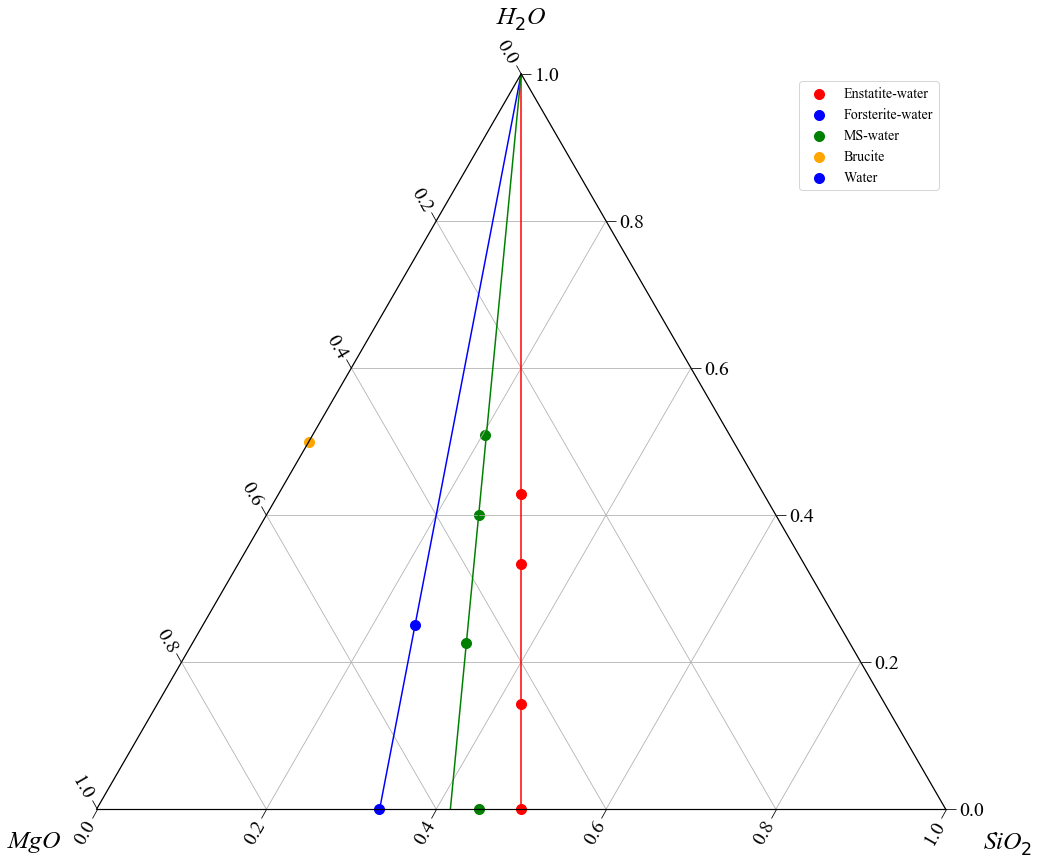

In [4]:
# Create ternary plot and populate with compositional data from table 1

%matplotlib inline

fig = plt.figure(figsize=(35, 0.866 * 35))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)

ax = fig.add_subplot(121, projection='ternary')

pc = ax.scatter(En[:, 4],
                En[:, 5],
                En[:, 6],
                c='red',
                label="Enstatite-water",
                clip_on=False,
                zorder=0)
pc = ax.scatter(Fo[:, 4],
                Fo[:, 5],
                Fo[:, 6],
                c='blue',
                label='Forsterite-water',
                clip_on=False)
pc = ax.scatter(MS[:, 4],
                MS[:, 5],
                MS[:, 6],
                c='green',
                label='MS-water',
                clip_on=False)
pc = ax.scatter(Br[:, 4],
                Br[:, 5],
                Br[:, 6],
                c='orange',
                label='Brucite',
                clip_on=False)
pc = ax.scatter(H2O[:, 4],
                H2O[:, 5],
                H2O[:, 6],
                c='blue',
                label='Water',
                clip_on=False)

ax.plot([1, 0], [0, .5], [0, .5], c='red')
ax.plot([1, 0], [0, 1], [0, .5], c='blue')
ax.plot([1, 0], [0, .7], [0, .5], c='green')

ax.set_tlabel('$H_2O$', fontsize=25)
ax.set_llabel('$MgO$', fontsize=25)
ax.set_rlabel('$SiO_2$', fontsize=25)

ax.taxis.set_label_rotation_mode('horizontal')
ax.laxis.set_label_rotation_mode('horizontal')
ax.raxis.set_label_rotation_mode('horizontal')

ax.legend(fontsize=14)
ax.tick_params(direction='out')
ax.grid()

<a id="table_2"></a>
#### Table 2: FPMD Simulation Conditions

The table below defines all of the conditions at which *ab initio* molecular dynamics (AIMD) simulations were performed in this study as well as additional data from other AIMD studies.

In [5]:
# Extract simulation conditions from text file and present as a table
PVTX_data = pd.read_csv('./PVTXu_data/simulated_PVTXu_data.csv')

PVTX_data

Composition Code,P (GPa),sigP (GPa),T (K),sigT (K),Vm (cm^3/mol),rho (g/cm^3),nu (Pa/s),signu (Pa/s),MgO (mol %),SiO2 (mol %),H2O (mol %),#Mg,#Si,#O,#H,Source


In [6]:
def extract_data(X, data_flag):
    """Given a composition code (e.g. X = 'En') and a flag (data_flag) extract_data returns
    all of the data from Table 2 required for subsequent fitting and plotting of PVTX data.
    
    Parameters
    ----------
    
    X         : string 
                composition code
    data_flag : int
                0 | 1 | 2 | 3 | 4 flag to determine how to search the data
            
    Returns
    -------
    
    P       : numpy array of float
              pressures
    s_P     : numpy array of float
              errors on pressures
    V       : numpy array of float
              volumes
    s_V     : numpy array of float
              errors on volumes (zero)
    T       : numpy array of float
              temperatures
    s_T     : numpy array of float
              errors on temperatures
    xMgO    : numpy array of float
              molar proportion of water
    s_xMgO  : numpy array of float
              errors in molar proportion of water (zero)
    xSiO2   : numpy array of float
              molar proportion of MgO
    s_xSiO2 : numpy array of float
              errors in molar proportion of MgO (zero)
    xH2O    : numpy array of float
              molar proportion of MgO
    s_xH2O  : numpy array of float
              errors in molar proportion of MgO (zero)
    u       : numpy array of float
              viscosities
    s_u     : numpy array of float
              errors on viscosities
    source  : numpy array of string
              data source
    """

    if data_flag == 0:
        X_mask = PVTX_data["Composition Code"].isin([X])
        fit_data = PVTX_data[X_mask]
    elif data_flag == 1:
        X_mask = PVTX_data["Composition Code"].str.contains(X)
        fit_data = PVTX_data[X_mask]
    elif data_flag == 2:
        fit_data = PVTX_data
    elif data_flag == 3:
        X_mask = (PVTX_data["Composition Code"].str.contains(X)) & (
            PVTX_data.iloc[:, 7].notnull())
        fit_data = PVTX_data[X_mask]
    elif data_flag == 4:
        X_mask = (PVTX_data["Composition Code"].isin(
            [X])) & (PVTX_data.iloc[:, 7].notnull())
        fit_data = PVTX_data[X_mask]

    P = fit_data.iloc[:, 1].to_numpy()
    s_P = fit_data.iloc[:, 2].to_numpy()

    T = fit_data.iloc[:, 3].to_numpy()
    s_T = fit_data.iloc[:, 4].to_numpy()

    V = fit_data.iloc[:, 5].to_numpy()

    u = fit_data.iloc[:, 7].to_numpy()
    s_u = fit_data.iloc[:, 8].to_numpy()

    xMgO = fit_data.iloc[:, 9].values / 100
    xSiO2 = fit_data.iloc[:, 10].values / 100
    xH2O = fit_data.iloc[:, 11].values / 100

    source = fit_data.iloc[:, 16].to_numpy()

    # Note there are no uncertainties on V or compositional parameters
    s_xH2O, s_xMgO, s_SiO2, s_V = [
        np.linspace(1e-10, 1e-10, len(V)) for i in range(4)
    ]

    return P, s_P, V, s_V, T, s_T, xMgO, s_xMgO, xSiO2, s_SiO2, xH2O, s_xH2O, u, s_u, source

In [7]:
def write_Burnman_dict(p, x):
    """Given an array of fitted parameters p, and an array, x, of V, T, xH2O and xMgO write_Burnman_dict returns
    a dictionary of parameters for subsequent use by the MGD function as implemented in Burnman. The function 
    caclulates V0, K0, K'0, q0, and grueneisen_0 and writes them into a dictionary. These five parameters are 
    linearly dependent on xMgO and quadratically dependent on xH2O (assuming all the flags in the ifixb flag 
    array of the scipy.ODR model are set to 1).
    
    Parameters
    ----------
    p    : 4 * 6 numpy array of float 
           fitted parameters
    x    : 1 x 2 numpy array 
           xMgO, xH2O
            
    Returns
    -------
    params : dict of float and int
           parameters V0, K0, K'0, grueneisen_0, q_0, Debye_0, T_0, P_0 and n(apfu)
    """

    # Calculate p0's via quadratic dependence on xH2O and linear dependence on xMgO referenced to MgSiO3
    p0 = np.empty(6)
    for i in range(6):
        p0[i] = p[0][i] + (p[1][i] *
                           (x[0] - 0.5)) + (p[2][i] * x[1]) + (p[3][i] *
                                                               (x[1]**2))

    oxygens = x[0] + x[1] + ((1 - (x[0] + x[1])) * 2)

    apfu = 3 + (2 * (x[1] * 3 / oxygens)) + (x[0] * 3 / oxygens) + (
        (1 - (x[1] + x[0])) * 3 / oxygens)

    # Create dictionary
    params = {
        "V_0": p0[0] / 1e6,  # Convert cm^3 to m^3
        "K_0": p0[1] * 1e9,  # Convert GPa to Pa
        "Kprime_0": p0[2],
        "grueneisen_0": p0[3],
        "q_0": p0[4],
        "Debye_0": p0[5],
        "T_0": 292,
        "P_0": 0,
        "n": apfu
    }

    return params

In [8]:
def MGD(p, x):
    """Given an array of fitted parameters p, and an array, x, of V, T, xH2O and xMgO MGD returns the total 
    pressure using the Mie-Grueneisen-Debye thermal equation of state as implemented in the Burnman code.
   
    Parameters
    ----------
    p    : rank-1 numpy array of float 
           fitted parameters
    x    : m x 4 numpy array 
           V, T, xMgO, xH2O
            
    Returns
    -------
    ptot : numpy array of float
           pressures in GPa
    """
    MGD_object = bm.eos.mie_grueneisen_debye.MGDBase()
    ptot = np.empty_like(x[0])
    for i, item in enumerate(ptot):
        params = write_Burnman_dict(np.reshape(p, (4, 6)), x.T[i][2:4])
        try:
            ptot[i] = MGD_object.pressure(x[1][i], x[0][i] / 1e6, params) / 1e9
        except:
            ptot[i] = np.nan

    return ptot

In [9]:
def perform_PVTX_fit(X, data_flag, ifixb):
    """Given a composition code (e.g. X = 'En') and a flag (data_flag), perform_fit gathers the required data,
    determines which parameters are to be fitted, constructs a fitting model, performs orthogonal distance
    regression to refine the fitted parameters and returns various goodness of fit statistics.
    
    Parameters
    ----------
    X         : string containing the composition code
    data_flag : int 
                flag to determine how to search the data
    ifixb     : 4 x 6 numpy array of int | int
                if array then represents fitting flags, 0 - do not fit | 1 - allow to vary
                if int then it is overwritten by perform_fit within if statement
            
    Returns
    -------
    P              : numpy array of float
                     pressures
    s_P            : numpy array of float
                     errors on pressures
    V              : numpy array of float
                     volumes
    T              : numpy array of float
                     temperatures
    xMgO           : numpy array of float
                     molar proportion of MgO
    xH2O           : numpy array of float
                     molar proportion of water
    fit.beta       : numpy array of float
                     fitted parameters
    ci_95          : numpy array of float
                     95% confidence intervals in fitted parameters
    fit.res_var    : float
                     reduced chi squared statistic
    r              : numpy array of float
                     r in volume 
    pcov           : n x n numpy array of float
                     covariance matrix
    DOF            : int
                     degrees of freedom of the fit
    fit.sum_square : numpy array of float
                     sum of squared errors
    source         : numpy array of string
                     name of data source
    ifixb          : array of int, same length as fit.beta
                     fitting flags, 0 - do not fit | 1 - allow to vary
    """

    P, s_P, V, s_V, T, s_T, xMgO, s_xMgO, xSiO2, s_SiO2, xH2O, s_xH2O, u, s_u, source = extract_data(
        X, data_flag)

    # Predictor variables
    x = [V, T, xMgO, xH2O]

    # Initial guesses for 4 x 6 = 24 fitted parameters: V0, K0, K'0, g0, q0, D0 in the form
    # i, di/dxMgO, di/dxH2O, d^2i/dxH2O^2
    beta0 = np.array([[33, 45, 6, .9, -1.1, 812], [0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

    # Set flags for fitting: 0 - do not fit, 1 - allow to vary, unless already defined.
    if isinstance(ifixb, int) == 1:
        if ifixb == 0:
            ifixb = np.array([[1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
        elif ifixb == 1:
            ifixb = np.array([[1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0],
                              [1, 1, 1, 1, 1, 0], [0, 0, 1, 0, 1, 0]])
        elif ifixb == 2:
            ifixb = np.array([[1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0],
                              [1, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0]])
        elif ifixb == 3:
            ifixb = np.array([[1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 0],
                              [1, 1, 1, 1, 1, 0], [0, 1, 1, 0, 1, 0]])

    # Define MGD model for ODR fitting
    MGD_odr = Model(MGD)

    # Create data structure for fitting. Note errors on V, xMgO and xH2O are zero.
    mydata = RealData(x, P, sx=[s_V, s_T, s_xMgO, s_xH2O], sy=s_P)

    # Create ODR instance for fitting
    myodr = ODR(mydata, MGD_odr, beta0.flatten(), ifixb=ifixb.flatten())

    fit = myodr.run()

    # Correct covariance matrix from ODR output (this is a bug; see https://github.com/scipy/scipy/issues/6842)
    # Note that fit.res_var is the reduced chi squared statistic and is identical to the value calculated
    # as from the sum of ((O-C)^2/sigma^2)/DOF
    pcov = fit.cov_beta * fit.res_var

    # Extract degrees of freedom (DOF) of fit
    DOF = len(V) - np.count_nonzero(ifixb)

    # Determine 95% confidence interval on the fitted parameters
    student_t_interval = stat.interval(0.95, DOF)
    ci_95 = student_t_interval[1] * fit.sd_beta

    # Determine pressure r
    r = P - MGD(fit.beta, np.array([V, T, xMgO, xH2O]))

    # Reshape variabled
    beta = np.reshape(fit.beta, (4, 6))
    errors = np.reshape(ci_95, (4, 6))
    ifixb = np.reshape(ifixb, (4, 6))
    
    return P, s_P, V, T, xMgO, xH2O, beta, errors, fit.res_var, r, pcov, DOF, fit.sum_square, source, ifixb

In [10]:
def cbands(func, beta, y, x, pcov, dof, ifixb):
    """The cbands function calculates confidence bands for any function. The function uses the delta method
    whereby the effect on y of a small deviation to each fitted parameter is used to calculate the partial
    derivative of the function with respect to that parameter. The covariance matrix of the fit is then 
    multiplied by this array of partial derivatives and its transpose to compute the variance at that value
    of y, which is converted to a confidence interval by multiplying its square root by the critical t value. 
    
    Parameters
    ----------
    func  : string
            name of function for which confidence bands are to be calculated
    beta  : rank-1 numpy array of float 
            fitted parameters
    y     : rank-1 numpy array of float
            response variable
    x     : m * n numpy array of float
            dependent variables
    pcov  : square numpy array of float
            covariance matrix
    DOF   : int
            degrees of freedom of the fit
    ifixb : array of int, same length as beta
            fitting flags, 0 - do not fit | 1 - allow to vary
            
    Returns
    -------
    ci_y  : numpy array of float, same length as P
            confidence intervals at each value of y
    
    """

    delta = 1e-3
    variance = np.empty_like(y)
    temp = []
    for i, item in enumerate(y):

        dy, dydbeta = (np.empty_like(beta) for i in range(2))
        for j, jtem in enumerate(beta):

            # Only compute partial derivitives for parameters that are allowed to vary
            if ifixb[j] == 1:
                temp = beta[j]
                beta[j] = beta[j] * (1 + delta)

                # Compute perturbed pressure
                try:
                    y_delta = func(beta, x[:, [i]])
                except:
                    y_delta = y[i]
                dy[j] = y[i] - y_delta

                # Compute partial derivative
                dydbeta[j] = dy[j] / (delta * beta[j])
                beta[j] = temp

        # Computer variance at point i and append to array
        variance[i] = dydbeta.T.dot(pcov).dot(dydbeta)

    # Critical t value at 95%
    Ct = stat.isf(0.5 * (0.95 + 1.), dof)

    # Confidence interval in y
    ci_y = (np.sqrt(variance) * Ct)

    return ci_y

In [11]:
def display_boxes(dropdown_box, box_name_list, nrows, ncols, ncols_row1, flag):
    """display_boxes handles the creation and arrangement of grids of textbox widgets for fit
    output.
    
    Parameters
    ----------
    dropdown_box  : widget object
                    dropdown menu
    box_name_list : list of string
                    names of widget objects
    nrows         : int
                    number of rows of fitted parameters
    ncols         : int
                    number of columns of fitted parameters
    ncols_row1    : int
                    number of text boxes in information row
    flag          : 0 | 1
                    flag to determine which titles to use
    
    Returns
    -------
    NONE
    """

    if flag == 0:
        titles = titles_PVT
    else:
        titles = titles_PuT

    # Create output boxes
    for i in range(0, len(box_name_list)):
        box_name_list[i] = w.Text(disabled=True,
                                  Value=[],
                                  layout=w.Layout(width='120px'))

    if ncols_row1 == 2:
        display(
            w.HBox([
                w.HTMLMath(titles[j], layout=w.Layout(width='120px'))
                for j in [0, -4, 4]
            ]))
        display(
            w.HBox([
                w.HBox([dropdown_box]),
                w.HBox([box_name_list[j] for j in range(0, ncols_row1)])
            ]))
    elif ncols_row1 == 1:
        display(w.HBox([w.HTMLMath(titles[4],
                                   layout=w.Layout(width='120px'))]))
        display(w.HBox([box_name_list[0]]))
    else:
        display(
            w.HBox([
                w.HTMLMath(titles[j], layout=w.Layout(width='120px'))
                for j in range(0, ncols_row1 + 1)
            ]))
        display(
            w.HBox([
                w.HBox([dropdown_box]),
                w.HBox([box_name_list[j] for j in range(0, ncols_row1)])
            ]))

    for i in range(nrows):
        display(
            w.HBox([
                w.HTMLMath(titles[j], layout=w.Layout(width='120px'))
                for j in range((i * ncols) + 5, ((i * ncols) + 5) + ncols)
            ]))
        display(
            w.HBox([
                box_name_list[j]
                for j in range((i * ncols) +
                               ncols_row1, ((i * ncols) + ncols_row1) + ncols)
            ]))

    display(
        w.HBox([
            w.HTMLMath(titles[j], layout=w.Layout(width='120px'))
            for j in range(-3, 0)
        ]))
    display(w.HBox([box_name_list[j] for j in range(-3, 0)]))


# Create lists of parameter titles
titles_PVT = [
    '$Composition$', '$H_2O$ $(mol\ \%)$', '$MgO$ $(mol\ \%)$',
    '$SiO_2$ $(mol\ \%)$', '$n$', "$V_0$", '$K_0$', '$K\'$', '$\gamma_0$',
    '$q$', '$θ_0$', "$dV_0/dx_{H2O}$", '$dK_0/dx_{H2O}$', '$dK\'/dx_{H2O}$',
    '$d\gamma_0/dx_{H2O}$','$dq/dx_{H2O}$','$dθ_0/dx_{H2O}$',
    "$d^2V_0/dx_{H2O}^2$", '$d^2K_0/dx_{H2O}^2$', '$d^2K\'/dx_{H2O}^2$',
    '$d^2\gamma_0/dx_{H2O}^2$', '$d^2q/dx_{H2O}^2$', '$d^2θ_0/dx_{H2O}^2$', 
    "$dV_0/dx_{MgO}$", '$dK_0/dx_{MgO}$', '$dK\'/dx_{MgO}$', '$d\gamma_0/dx_{MgO}$',
    '$dq/dx_{MgO}$', '$dθ_0/dx_{MgO}$',  '$MgO/SiO_2$', 'Residual (GPa)',
    'DOF', '$\chi_\nu^2$'
]

titles_PuT = [
    '', '', '', '', '$n$', '$a_{MgO}$', '$b_{MgO}$', '$c_{MgO}$', '$d_{MgO}$',
    '$e_{MgO}$', '$a_{SiO2}$', '$b_{SiO2}$', '$c_{SiO2}$', '$d_{SiO2}$',
    '$e_{SiO2}$', '$a_{H2O}$', '$b_{H2O}$', '$c_{H2O}$', '$d_{H2O}$',
    '$e_{H2O}$', 'Residual (%)', 'DOF', '$\chi_\nu^2$'
]

In [12]:
def custom_colors(T, list_of_isotherms):
    """Given a list of temperatures and a list of isotherms to be plotted, custom_colors returns
    the minimum and maximum temperatures within the plot and a custom ScalarMappable object for
    use in producing colorbars with custom normalisation.
    
    Parameters
    ----------
    T                 : numpy array of float
                        plotted temperatures
    list_of_isotherms : numpy array of float
                        list of plotted isotherms
                        
    Returns
    -------
    vmin           : float
                     minimum T on plot
    vmax           : float
                     maximum T on plot
    ScalarMappable : ScalarMappable Object
                     for production of custom colorbars
    """

    vmin, vmax = min(min(T),
                     min(list_of_isotherms)), max(max(T),
                                                  max(list_of_isotherms))

    cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    return vmin, vmax, mpl.cm.ScalarMappable(norm=cNorm, cmap='cool')

In [13]:
def PVT_plot(P, s_P, V, T, xMgO, xH2O, r, name, source, beta, pcov, dof,
             ifixb):
    """Handles plotting of data, isotherms, confidence bands and residuals.
    
    Parameters
    ----------
    P         : numpy array of float
                pressures
    s_P       : numpy array of float
                errors in P
    V         : numpy array of float
                volumes
    T         : numpy array of float
                temperatures
    xH2O      : numpy array of float
                molar proportion of water
    xMgO      : numpy array of float
                molar proportion of water
    r         : numpy array of float
                pressure residual
    name      : string
                composition code of current plot
    source    : numpy array of string
                list of data sources
    beta      : m * n numpy array of float
                fitted parameters
    pcov      : n x n numpy array of float
                covariance matrix
    DOF       : int
                degrees of freedom of the fit
    ifixb     : array of int, same length as beta
                fitting flags, 0 - do not fit | 1 - allow to vary
                
    Returns
    -------
    fig : figure object
    """

    %matplotlib inline

    # Calculate isotherms and confidence bands
    V_range = np.linspace(min(V) * 0.75, max(V) * 1.1, 100)
    i_xMgO = np.linspace(xMgO[0], xMgO[0], len(V_range))
    i_xH2O = np.linspace(xH2O[0], xH2O[0], len(V_range))
    i_T = np.ones(len(V_range))
    iso_list = np.unique(np.round(T, -2))
    P_range = [[1e-10 for j in range(len(V_range))]
               for i in range(len(iso_list))]
    ci = [[1e-10 for j in range(len(V_range))] for i in range(len(iso_list))]
    for i, item in enumerate(tqdm(iso_list, desc='Processing', leave=False)):
        P_range[i] = MGD(beta, np.array([V_range, i_T * item, i_xMgO, i_xH2O]))
        ci[i] = cbands(MGD, beta.flatten(), P_range[i],
                       np.array([V_range, i_T * item, i_xMgO, i_xH2O]), pcov,
                       dof, ifixb.flatten())

    fig = plt.figure(num=None,
                     figsize=(11, 11 * .66),
                     dpi=80,
                     facecolor='w',
                     edgecolor='w')

    # Set up main plot
    vmin, vmax, scalarMap = custom_colors(T, [1800, 3000])
    ax1 = fig.add_axes((.195, .3, .98, .66))
    ax1.set_xticklabels([])
    plt.ylabel('Volume, $V$ (cm$^3$/mol)', fontsize=20)
    ax1.annotate(name, [0.2, 0.9], xycoords='axes fraction', fontsize=20)
    ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

    # Set up residual plot
    ax2 = fig.add_axes((.195, 0.05, .98, .2))
    ax2.axhline(linestyle='--', color='k')
    plt.xlabel('Pressure, $p$ $(GPa)$', fontsize=20)
    plt.ylabel('Residuals (GPa)', fontsize=20)
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

    # Plot data and residuals
    source_set = list(set(source))
    marker_list = itertools.cycle(('o', 's'))
    for i, item in enumerate(source_set):
        marker = next(marker_list)
        ax1.scatter(P[source == source_set[i]],
                    V[source == source_set[i]],
                    marker=marker,
                    label=item,
                    color=scalarMap.to_rgba(T[source == source_set[i]]))
        ax2.scatter(P[source == source_set[i]],
                    r[source == source_set[i]],
                    marker=marker,
                    color=scalarMap.to_rgba(T[source == source_set[i]]))

    # Make x-axis range the same on both main and residual plots
    left, right = ax2.get_xlim()
    ax1.set_xlim(left, right)

    # Plot isotherms and confidence bands
    for i in range(len(P_range)):
        ax1.plot(P_range[i], V_range, color=scalarMap.to_rgba(iso_list[i]))
        ax1.fill_betweenx(V_range,
                          P_range[i] + ci[i],
                          P_range[i] - ci[i],
                          color=scalarMap.to_rgba(iso_list[i]),
                          alpha=0.3,
                          linewidth=0)
        ax2.fill_between(P_range[i],
                         ci[i],
                         -ci[i],
                         color=scalarMap.to_rgba(iso_list[i]),
                         alpha=0.3,
                         linewidth=0,
                         zorder=i)

    # Make x-axis range the same on both main and residual plots
    ax2.set_xlim(left, right)

    # Make y-axis limits sensible
    ax1.set_ylim(
        min(V) - ((max(V) - min(V)) * 0.1),
        max(V) + ((max(V) - min(V)) * 0.1))
    ax2.set_ylim(-max(abs(r)) * 2, max(abs(r)) * 2)

    # Plot colorbar
    ax3 = fig.add_axes((.83, .88, .3, .05))
    cbar = fig.colorbar(scalarMap, cax=ax3, orientation="horizontal")
    cbar.set_label('$T/K$', fontsize=20, labelpad=-15)
    cbar.set_ticks([vmin, vmax])

    ax1.legend(loc=[0.63, 0.63], frameon=False, fontsize=16, markerscale=2)

    return fig

<hr style="height:10px;border-width:0;color:gray;background-color:gray">

### Volume: Fitting a single composition

Below ([Widget 1](#widget_1)) you can choose a single composition and fit it using the Mie-Gruneisen-Debye (MGD) pressure-volume-temperature Equation of State (EoS). Note that the Debye temperature $\theta_D$ is fixed at 812 K, the value for pure enstatite at ambient conditions<sup>1</sup>. This assumption is made because of the lack of information on the Debye temperatures of silicate liquids, and has a minimal impact on the quality of the fit. Left to vary, this parameter minimises $\chi^2_\nu$ at $~0 K$, which is physically unreasonable. The fitted parameters are therefore the molar volume at 1 atmosphere and 298 K, $V_0$, the bulk modulus $K_0$ and its pressure derivative $K'_0$, the Grueneisen parameter at ambient conditions, $\gamma_0$, which determines the strength of the dependance of the thermal expansion on the volume and the exponent $q_0$ which determines the effect of compression on $\gamma_0$.

The form of the MGD function used for fitting is based on the equations set out in Appendix B of Matas et al. (2007)<sup>2</sup>. The fit is performed using orthogonal distance regression rather than ordinary least squares regression and thus the data are weighted based on the uncertainties in all the predictor variables, $V$, $T$, $xH_2O$ and $xMgO$ as well as the response variable $P$. In reality, the uncertainties in $V$, $xH_2O$ and $MgO$ are all zero because these are fixed parameters in the AIMD simulations.

________________

<sup>1</sup>Yang, H., Ghose, S. Thermal expansion, Debye temperature and Grüneisen parameter of synthetic (Fe, Mg)SiO3 orthopyroxenes. Phys Chem Minerals 20, 575–586 (1994). https://doi.org/10.1007/BF00211853

<sup>2</sup>Matas, J., Bass, J., Ricard, Y., Mattern, E., Bukowinski, M. (2007). On the bulk composition of the lower mantle: predictions and limitations from generalized inversion of radial seismic profiles Geophysical Journal International  170(2), 764 - 780. https://dx.doi.org/10.1111/j.1365-246x.2007.03454.x

<a id="widget_1"></a>

<div class="alert alert-block alert-info">
    
#### Widget 1: Fitting a single composition
<br />
</div>

In [14]:
def fit_uX(change):
    """Callback function called when dropdown menu uX is changed. Executes fit, calculates isotherms
    and confidence bands and plots the results.
    
    Parameters
    ----------
    change : object containing a type key (i.e. 'change') and a name key (i.e. 'En'), corresponding 
             respectively to the type of notification and the name of the triggering attribute.
             
    Returns
    -------
    NONE
             
    """
    if change['type'] == 'change' and change['name'] == 'value':

        # Populate box row 1 with compositional information
        for i in range(4):
            bx1[i].value = str(
                compositions.iloc[compositions.index.get_loc(change['new']),
                                  4 + i])

        # Perform the ODR fit
        P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
            change['new'], 0, 0)

        # Populate box row 2 with refined parameters and their 95% confidence intervals (2SD)
        for i in range(6):
            bx1[i + 4].value = str(np.round(beta[0][i], 2)) + '±' + str(
                np.round(errors[0][i], 2))

        # Populate box row 3 with fit statistics
        bx1[10].value = str(np.round(np.mean(np.abs(r)), 3))
        bx1[11].value = str(np.round(dof, 3))
        bx1[12].value = str(np.round(chi, 3))

        fig = PVT_plot(P, s_P, V, T, xMgO, xH2O, r, change['new'], source,
                       beta, pcov, dof, ifixb)

        # Update plot
        with out1:
            clear_output(wait=True)
            plt.show(fig)


# Set up interactive dropdown menu
uX = w.Dropdown(options=compositions.index.values.tolist(),
                layout=w.Layout(width='120px'))
uX.value = uX.options[1]
uX.observe(fit_uX)

# Create lists of box names
bx1 = [
    "b0", "b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11",
    "b12"
]

# Draw output boxes
display_boxes(uX, bx1, 1, 6, 4, 0)

# Create output widget for plotting figure
out1 = w.Output()

display(w.HBox([out1]))

# Trigger callback on cell initialisation
uX.value = uX.options[0]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

<hr style="height:10px;border-width:0;color:gray;background-color:gray">

### Volume: Fitting a binary

All five variables in the MGD equation show a non-linear dependence on $xH_2O$ ([figure 2](#figure_2)). We have tested all 32 possible combinations of linear and quadratic dependence for all five variables ([table 3](#table_3)) along the En-H<sub>2</sub>O binary. We find that a combination of linear dependence for $V_0$, $K_0$ and $q_0$ and quadratic dependence for $K'_0$ and $\gamma_0$ produces the fit with the lowest reduced chi squared statistic ($\chi_\nu^2$) such that, for example,

$$K_{0,298}=K_{0,0,298}+(x.dK_{0,298}/dx)$$

and

$$K'_{0,298,x}=K'_{0,298,0}+(x.dK'_{0,298}/dx)+(x^2.d^2K'_{0,298}/dx^2)$$

where the subscripts represent $P$, $T$ and the molar proportion of water per formula unit ($xH_2O$). 

Similar tests on the MS-H<sub>2</sub>O binary produced minimal variation in $\chi_\nu^2$, while tests on the Fo-H<sub>2</sub>O binary produced unphysical results regardless of which parameters were allowed quadratic dependence because there are only two compositions in the dataset. We are therefore implicitly assuming that the effect of water on the thermophysical parameters for enstatite composition liquids is applicable to all silicate compositions along the MgO-SiO<sub>2</sub> join.

In [Widget 2](#widget_2) you can choose one of the three binaries (En-H<sub>2</sub>O, Fo-H<sub>2</sub>O or MS-H<sub>2</sub>O) within the MgO-SiO<sub>2</sub>-H<sub>2</sub>O ternary system and fit it to a single PVTX EoS using the compositional dependence described above. You can then view isopleths at each simulated composition in [Widget 3](#widget_3).

Note that the anhydrous MS composition does not lie on the binary defined by the hydrous MS compositions due to an error in the simulations. As a result, this composition is not included in the binary fit.

<a id="figure_2"></a>

#### Figure 2: Variation in fitted parameters as a function of water content

The six plots below show how the fitted parameters vary as a function of water content along the En-H<sub>2</sub>O, MS-H<sub>2</sub>O and Fo-H<sub>2</sub>O joins when each *composition* is fitted individually. The lines indicate linear (blue) and 2</sup>nd</sup> order polynomial fits to the data respectively. Note that $\theta_0$ does not vary as the parameter is fixed.

In [15]:
def param_var_callback(change):
    """Callback function called when dropdown menu pv is changed by the user selecting
    a different composition. Executes fits for each composition separately along the selected join,
    and plots the value of each fitted parameter as a function of water content. These data are then
    fitted using both a linear and second order polynomial function.
    
    Parameters
    ----------
    change : object containing a type key (i.e. 'change') and a name key (i.e. 'En'), corresponding 
             respectively to the type of notification and the name of the attribute that triggered 
             the notification.
             
    Returns
    -------
    NONE
    """
    if change['type'] == 'change' and change['name'] == 'value':

        # Create list of all compositions along the En-H2O join
        test_list = compositions.index[compositions.index.str.contains(
            '|'.join([change['new'], 'H2O']))].tolist()

        # Loop over every composition
        beta = [[1e-10 for j in range(24)] for i in range(len(test_list))]
        xH2O_test = [1e-10 for j in range(len(test_list))]
        for i, item in enumerate(test_list):

            # Perform the ODR fit
            P, s_P, V, T, xMgO, xH2O, beta[
                i], errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
                    item, 0, 0)

            xH2O_test[i] = xH2O[0]
            
        # Create grid of plots
        fig, axs = plt.subplots(2,
                                3,
                                figsize=(16, 8),
                                facecolor='w',
                                edgecolor='w')
        fig.subplots_adjust(hspace=.001, wspace=.45)

        # Create contiguous flattened, iterable array from matrix of subplots
        axs = axs.ravel()

        for i in range(6):
            quad_fit = np.polyfit(xH2O_test, [item[0][i] for item in beta], 2)
            lin_fit = np.polyfit(xH2O_test, [item[0][i] for item in beta], 1)
            axs[i].plot(xH2O_test, [item[0][i] for item in beta], 'ro')
            axs[i].plot(
                np.linspace(0, max(xH2O_test), 100),
                np.polyval(quad_fit, np.linspace(0, max(xH2O_test), 100)),
                'r-')
            axs[i].plot(
                np.linspace(0, max(xH2O_test), 100),
                np.polyval(lin_fit, np.linspace(0, max(xH2O_test), 100)), 'b-')
            axs[i].set_xlabel('$xH2O$', fontsize=20)
            axs[i].set_ylabel(titles_PVT[i + 5], fontsize=20)
            axs[i].ticklabel_format(useOffset=False, style='plain')

        axs[5].set_ylim((811, 813))

        with out_pv:
            clear_output(wait=True)
            plt.show(fig)


# Set up interactive dropdown menu
pv = w.Dropdown(options=['En', 'MS', 'Fo'], layout=w.Layout(width='120px'))
pv.value = pv.options[1]
pv.observe(param_var_callback)

# Draw output boxes
display(w.VBox([w.HTMLMath(titles_PVT[0]), pv]))

# Create output widget for plotting figure
out_pv = w.Output()

display(w.HBox([out_pv]))

# Trigger callback on cell initialisation
pv.value = pv.options[0]

<a id="table_3"></a>

#### Table 3: Binary fit testing 

The table below contains the results of 32 fits to all the data along the En-H<sub>2</sub>O binary, each with a different combination of linear and quadratic dependence on the water content for the five parameters that are allowed to vary ($V_0$, $K_0$, $K'_0$,$\gamma_0$ and $q_0$).  

In [16]:
def fit_test(code, data_flag, ifixb):
    """Function to perform fit testing by iterating through all possible combinations of linear | quadratic
    for all five fitted variables.
    
    Parameters
    ----------
    code      : string
                Name of composition to be fitted
    ifixb     : 4 x 6 numpy array of int
                array contains fitting flags, 0 - do not fit | 1 - allow to vary
    data_flag : int 
                flag to determine how to search the data

    Returns
    -------
    df      : Pandas dataframe object
    """

    # Create list of binary words of all combinations for five parameters
    com_tuple = list(itertools.product([0, 1], repeat=5))

    # Convert to list of lists from list of tuple
    com_list = [list(elem) for elem in com_tuple]

    result = np.zeros([len(com_list), 9])
    for i in tqdm(range(len(com_list)), desc='Processing', leave=False):

        # Update 'column' 4 with current linear/quadratic combination
        ifixb[3][0:5] = com_list[i]

        # Perform ODR fit
        P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
            code, data_flag, ifixb)

        result[i] = [*ifixb[3][0:5], 2., np.mean(np.abs(r)), dof, chi]

    # Create pandas dataframe to contain results
    df = pd.DataFrame(result,
                      columns=[
                          'V0', 'K0', 'K\'0', 'g0', 'q0', 'TD,0',
                          'Mean residual (cm3/mol)', 'DOF', 'Reduced chi^2'
                      ])

    # Convert numeric output to meaningfull strings
    df.replace(0, 'Linear', inplace=True)
    df.replace(1, 'Quadratic', inplace=True)
    df.replace(2, 'Fixed', inplace=True)
    return df

In [17]:
def binary_fit_test_callback(b):
    """Callback function called when button0 is clicked. Subsequently calls fit testing function
    
    Parameters
    ----------
    b:       the clicked button widget instance
             
    Returns
    -------
    NONE
    """

    # Perform fit test with intial ifixb with all variables linear
    binary_fit_test_results = fit_test(
        'En', 1,
        np.array([[1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0]]))

    # Update dataframe
    with out0:
        clear_output(wait=True)
        display(binary_fit_test_results)


# Create button widget
button0 = w.Button(description='Re-calculate',
                   disabled=False,
                   button_style='success',
                   tooltip='Calculate',
                   icon='check',
                   layout={
                       'margin': '0px 0px 20px 0px',
                       'width': '100%'
                   })

# Link button to callback function
button0.on_click(binary_fit_test_callback)

# Create output widget for plotting table
out0 = w.Output()

# Draw everything
display(w.VBox([button0, out0]))

# Read in dataframe from .csv in local directory containing fitting results
binary_fit_test_results = pd.read_csv(
    './PVTXu_data/binary_fit_test_results.csv')

# Draw dataframe in output widget container
with out0:
    display(binary_fit_test_results)

<a id="widget_2"></a>

<div class="alert alert-block alert-info">
    
#### Widget 2: Fitting a binary
<br />
</div>

In [18]:
def PVTX_plot(P, V, T, xH2O, xMgO, source, beta):
    """Handles plotting of data, isotherms, confidence bands and r on a 2-D surface plot.
    
    Parameters
    ----------
    P         : numpy array of float
                pressures
    V         : numpy array of float
                volumes
    T         : numpy array of float
                temperatures
    source    : numpy array of string
                list of data sources
    p         : numpy array of float 
                fitted parameters
    apfu      : numpy array of float
                atoms per formula unit
                
    Returns
    -------
    fig : figure object
    """

    %matplotlib inline
    plt.ioff()

    # Calculate isotherms and confidence bands
    res = 50
    V_range = np.tile(np.linspace(min(V), max(V), res), res)
    i_xH2O = np.repeat(np.linspace(min(xH2O), max(xH2O), res), res)
    i_xMgO = np.tile(np.linspace(xMgO[0], xMgO[0], res), res)
    i_T = np.ones(len(V_range))
    iso_list = np.unique(np.round(T, -2))
    P_range = [[1e-10 for j in range(len(V_range))]
               for i in range(len(iso_list))]
    for i, item in enumerate(tqdm(iso_list, desc='Processing', leave=False)):
        P_range[i] = MGD(beta, np.array([V_range, i_T * item, i_xMgO, i_xH2O]))

    fig = plt.figure(num=None,
                     figsize=(15, 15 * .66),
                     dpi=80,
                     facecolor='w',
                     edgecolor='w')

    vmin, vmax, scalarMap = custom_colors(T, [1800, 6000])

    # Set up plot
    ax1 = fig.gca(projection='3d')
    ax1.set_xlabel('Pressure, $p$ $(GPa)$', fontsize=20, labelpad=15)
    ax1.set_ylabel('Composition, $xH_2O$', fontsize=20, labelpad=15)
    ax1.set_zlabel('Volume, $V$ (cm$^3$/mol)', fontsize=20, labelpad=15)
    ax1.set_zlim(np.nanmin(V_range) * .9, np.nanmax(V_range) * 1.1)
    ax1.set_xlim(min(P), max(P))

    # Plot data
    source_set = list(set(source))
    marker_list = itertools.cycle(('o', 's'))
    for i, item in enumerate(source_set):
        marker = next(marker_list)
        ax1.scatter3D(P[source == source_set[i]],
                      xH2O[source == source_set[i]],
                      V[source == source_set[i]],
                      label=item,
                      marker=marker,
                      color=scalarMap.to_rgba(T[source == source_set[i]]))

    # Plot isosurfaces
    for i, item in enumerate(iso_list):
        color = scalarMap.to_rgba(iso_list[i])
        ax1.plot_surface(P_range[i].reshape(res, res),
                         i_xH2O.reshape(res, res),
                         V_range.reshape(res, res),
                         rstride=1,
                         color=color,
                         edgecolor='none',
                         alpha=0.25)

    ax1.legend(loc=[0.3, 0.95], frameon=False, fontsize=16, markerscale=2)

    return fig

In [19]:
def fit_bX(change):
    """Callback function called when dropdown menu bX is changed. Executes fit, calculates isosurfaces
    and and plots the results.
    
    Parameters
    ----------
    change : object containing a type key (i.e. 'change') and a name key (i.e. 'En'), corresponding 
             respectively to the type of notification and the name of the attribute that triggered 
             the notification.
             
    Returns
    -------
    NONE
    """

    if change['type'] == 'change' and change['name'] == 'value':

        # Populate box row 1 with compositional information
        cx1[0].value = str(
            np.round(eval(change['new'])[0, 5] / eval(change['new'])[0, 6], 2))
        cx1[1].value = str(int(np.sum(eval(change['new'])[:, -1])))

        # Perform ODR fit
        if change['new'] == 'Fo':
            P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
                change['new'], 1, 2)
        else:
            P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
                change['new'], 1, 1)
        
        # Populate box rows 2-4 with refined parameters and their 95% confidence intervals (2SD)
        for i in range(6):
            cx1[i + 2].value = str(np.round(beta[0][i], 2)) + '±' + str(
                np.round(errors[0][i], 2))
            cx1[i + 8].value = str(np.round(beta[2][i], 2)) + '±' + str(
                np.round(errors[2][i], 2))
            cx1[i + 14].value = str(np.round(beta[3][i], 2)) + '±' + str(
                np.round(errors[3][i], 2))

        # Populate box row 5 with fit statistics
        cx1[20].value = str(np.round(np.mean(np.abs(r)), 3))
        cx1[21].value = str(np.round(dof, 3))
        cx1[22].value = str(np.round(chi, 3))

        # If sub_bX dropdown widget exists, update its options and value based on chosen binary
        if 'sub_bX' in globals():
            sub_bX.options = compositions.index[
                compositions.index.str.contains('|'.join(
                    [change['new'], 'H2O']))].tolist()
            sub_bX.value = sub_bX.options[1]

        fig1 = PVTX_plot(P, V, T, xH2O, xMgO, source, beta)

        # Update plot
        with out2:
            clear_output(wait=True)
            plt.show(fig1)


# Set up interactive dropdown menu
bX = w.Dropdown(options=['En', 'MS', 'Fo'], layout=w.Layout(width='120px'))
bX.value = bX.options[1]
bX.observe(fit_bX)

# Create lists of box names
cx1 = [
    "c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10", "c11",
    "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19", "c20", "c21", "c22"
]

# Draw output boxes
display_boxes(bX, cx1, 3, 6, 2, 0)

# Create output widget for plotting figure
out2 = w.Output()

display(w.HBox([out2]))

# Trigger callback on cell initialisation
bX.value = bX.options[0]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<a id="widget_3"></a>

<div class="alert alert-block alert-info">
    
#### Widget 3: View a single composition within the binary fit
<br />
</div>

In [20]:
def bX_isopleth(change):
    """Callback function called when dropdown menu sub_bX is changed, either by the user selecting
    a different composition to fit within the current binary, or by the user changing dropdown bX in
    the previous cell. Executes fit, calculates isotherms and confidence bands and plots the results.
    
    Parameters
    ----------
    change : object containing a type key (i.e. 'change') and a name key (i.e. 'En'), corresponding 
             respectively to the type of notification and the name of the attribute that triggered 
             the notification.
             
    Returns
    -------
    NONE
    """

    if change['type'] == 'change' and change['name'] == 'value':

        # Populate box row 1 with compositional information
        for i in range(4):
            dx1[i].value = str(
                compositions.iloc[compositions.index.get_loc(change['new']),
                                  4 + i])
        
        # Determine which binary we are in
        bin_comp = bX.value

        # Perform ODR fit
        if bin_comp == 'Fo':
            P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
                bin_comp, 1, 2)
        else:
            P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
                bin_comp, 1, 1)

        # Get data for current composition
        P, s_P, V, s_V, T, s_T, xMgO, s_xMgO, xSiO2, s_SiO2, xH2O, s_xH2O, u, s_u, source = extract_data(
            change['new'], 0)

        # Calculate r
        r = P - MGD(beta, np.array([V, T, xMgO, xH2O]))
        dx1[4].value = str(np.round(np.mean(abs(r)), 3))
        fig2 = PVT_plot(P, s_P, V, T, xMgO, xH2O, r, change['new'], source,
                        beta, pcov, dof, ifixb)

        # Update plot
        with out3:
            clear_output(wait=True)
            plt.show(fig2)
        return beta, pcov, dof, ifixb


# Set up interactive dropdown menu
sub_bX = w.Dropdown(options=compositions.index[compositions.index.str.contains(
    bX.value)].tolist(),
                    layout=w.Layout(width='120px'))
sub_bX.value = sub_bX.options[1]
sub_bX.observe(bX_isopleth)

# Create lists of box names
dx1 = ["d1", "d2", "d3", "d4", "d5"]

# Create output text boxes
for i in range(5):
    dx1[i] = w.Text(disabled=True, Value=[], layout=w.Layout(width='120px'))

# Create output widget for plotting figure
out3 = w.Output()

# Draw everything
display(
    w.HBox([
        w.HTMLMath(titles_PVT[i], layout=w.Layout(width="120px"))
        for i in [0, 1, 2, 3, 4, 30]
    ]))
display(w.HBox([sub_bX, dx1[0], dx1[1], dx1[2], dx1[3], dx1[4]]))
display(out3)

# Trigger callback on cell initialisation
sub_bX.value = sub_bX.options[0]

Output()

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

<hr style="height:10px;border-width:0;color:gray;background-color:gray">

### Volume: Fitting the ternary

Immediately below is our fit to the entire ternary dataset presented in [Table 2](#table_2), including all of the literature data. In this case not only is each parameter either linearly or quadratically dependent on the molar proportion of H<sub>2</sub>O, but they are also linearly dependent on molar proportion of MgO, with enstatite being the reference composition. Each fitted parameter is calculated as in the example below for the bulk modulus:

$$K_{0,298,x,y}=K_{0,298,0,0.5}+dK_{0,298,x,0.5}/dx+(y.dK_{0,298}/dy - 0.5)$$

where the subscripts represent P, T and the molar proportions of H<sub>2</sub>O and MgO respectively and where $K_{0,298,0,0.5}$ is the bulk modulus of anhydrous enstatite and the $dK_{0,298,x,0.5}/dx$ term represents the dependence of the bulk modulus on the water content.

As with the binary fitting, careful fit testing has been perfomred on all 32 combinations of linear and quadratic dependencies on the molar proportion of H<sub>2</sub>O for the five fitted variables. In this case, the lowest $\chi_\nu^2$ is produced when $K_0$, $K'_0$ and $\gamma_0$ have a quadratic dependence on the molar proportion of H<sub>2</sub>O. The results of these fitting tests are shown in [Table 4](#table_4).

You can view isopleths at each simulated composition wihtin the ternary in [Widget 4](#widget_4).

In [21]:
def tX():
    """Performs MGD PVTX fit to all data in MSH ternary.
                
    Returns
    -------
    beta   : 4 x 6 numpy array of float
             fitted parameters
    errors : 4 x 6 numpy array of float
             95% confidence intervals in fitted parameters
    pcov   : n x n numpy array of float
             covariance matrix
    DOF    : int
             degrees of freedom of the fit
    """
    # Create lists of names for textboxes
    dx1 = [
        "d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "d8", "d9", "d10",
        "d11", "d12", "d13", "d14", "d15", "d16", "d17", "d18", "d19", "d20",
        "d21", "d22", "d23", "d24", "d25", "d26", "d27"
    ]

    # Draw output boxes
    display_boxes([], dx1, 4, 6, 1, 0)

    # Perform ODR ternary fit
    P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
        '', 2, 3)

    # Populate box row 1 with compositional information
    dx1[0].value = str(len(P))

    # Populate box rows 2-9 with refined parameters and their 95% confidence intervals (2SD)
    for i in range(6):
        dx1[i + 1].value = str(np.round(beta[0][i], 2)) + '±' + str(
            np.round(errors[0][i], 2))
        dx1[i + 7].value = str(np.round(beta[2][i], 2)) + '±' + str(
            np.round(errors[2][i], 2))
        dx1[i + 13].value = str(np.round(beta[3][i], 2)) + '±' + str(
            np.round(errors[3][i], 2))
        dx1[i + 19].value = str(np.round(beta[1][i], 2)) + '±' + str(
            np.round(errors[1][i], 2))

    # Populate box row 8 with fit statistics
    dx1[25].value = str(np.round(np.mean(np.abs(r)), 2))
    dx1[26].value = str(np.round(dof, 3))
    dx1[27].value = str(np.round(chi, 3))

    return beta, errors, pcov, dof, ifixb


v_beta, v_errors, v_pcov, v_dof, v_ifixb = tX()

<a id="table_4"></a>

#### Table 4: Ternary fit testing 

The table below contains the results of 32 fits to all the data within the ternary, each with a different combination of linear and quadratic dependence of the water content for the five parameters that are allowed to vary ($V_0$, $K_0$, $K'_0$,$\gamma_0$ and $q_0$) while each parameter has a linear dependence on the $MgO$ content.

In [22]:
def ternary_fit_test_callback(b):
    """Callback function called when button0 is clicked. Subsequently calls fit testing function
    
    Parameters
    ----------
    b:       the clicked button widget instance
             
    Returns
    -------
    NONE
    """

    # Perform fit test with intial ifixb with all variables linear
    ternary_fit_test_results = fit_test(
        '', 2,
        np.array([[1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0]]))

    # Update dataframe
    with out01:
        clear_output(wait=True)
        display(ternary_fit_test_results)


# Create button widget
button01 = w.Button(description='Re-calculate',
                    disabled=False,
                    button_style='success',
                    tooltip='Calculate',
                    icon='check',
                    layout={
                        'margin': '0px 0px 20px 0px',
                        'width': '100%'
                    })

# Link button to callback function
button01.on_click(ternary_fit_test_callback)

# Create output widget for plotting table
out01 = w.Output()

# Draw everything
display(w.VBox([button01, out01]))

# Read in dataframe from .csv in local directory containing fitting results
ternary_fit_test_results = pd.read_csv(
    './PVTXu_data/ternary_fit_test_results.csv')

# Draw dataframe in output widget container
with out01:
    display(ternary_fit_test_results)

<a id="widget_4"></a>

<div class="alert alert-block alert-info">
    
#### Widget 4: View a single composition within the ternary fit
<br />
</div>

In [23]:
def tX_isopleth(change):
    """Callback function called when dropdown menu sub_tX is changed. Executes fit, calculates isotherms
    and confidence bands and plots the results.
    
    Parameters
    ----------
    change : object containing a type key (i.e. 'change') and a name key (i.e. 'En'), corresponding 
             respectively to the type of notification and the name of the attribute that triggered 
             the notification.
             
    Returns
    -------
    NONE
    """
    if change['type'] == 'change' and change['name'] == 'value':

        # Populate box row 1 with compositional information
        for i in range(4):
            fx1[i].value = str(
                compositions.iloc[compositions.index.get_loc(change['new']),
                                  4 + i])

        # Perform ODR ternary fit
        P, s_P, V, T, xMgO, xH2O, beta, errors, chi, r, pcov, dof, ss, source, ifixb = perform_PVTX_fit(
            '', 2, 3)

        # Get data for current composition
        P, s_P, V, s_V, T, s_T, xMgO, s_xMgO, xSiO2, s_SiO2, xH2O, s_xH2O, u, s_u, source = extract_data(
            change['new'], 0)

        # Calculate r
        r = P - MGD(beta, np.array([V, T, xMgO, xH2O]))
        fx1[4].value = str(np.round(np.mean(abs(r)), 3))
        fig3 = PVT_plot(P, s_P, V, T, xMgO, xH2O, r, change['new'], source,
                        beta, pcov, dof, ifixb)

        with out4:
            clear_output(wait=True)
            plt.show(fig3)


# Set up interactive dropdown menu
sub_tX = w.Dropdown(options=compositions.index.tolist(),
                    layout=w.Layout(width='120px'))
sub_tX.value = sub_tX.options[1]
sub_tX.observe(tX_isopleth)

# Create lists of box names
fx1 = ["e1", "e2", "e3", "e4", "e5"]

# Create output text boxes
for i in range(5):
    fx1[i] = w.Text(disabled=True, Value=[], layout=w.Layout(width='120px'))

# Create output widget for plotting figure
out4 = w.Output()

# Draw everything
display(
    w.HBox([
        w.HTMLMath(titles_PVT[i], layout=w.Layout(width="120px"))
        for i in [0, 1, 2, 3, 4, 30]
    ]))
display(w.HBox([sub_tX, fx1[0], fx1[1], fx1[2], fx1[3], fx1[4]]))
display(out4)

# Trigger callback on cell initialisation
sub_tX.value = sub_tX.options[0]

Output()

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

<hr style="height:10px;border-width:0;color:gray;background-color:gray">

### Viscosity: Fitting the ternary

We have fitted the viscosities for the full range of simulated melts listed in [Table 2](#table_2) to the modified Vogel-Fulcher-Tammann-Hesse (VFTH) function

$\eta(p,T,x_M,x_S,x_H) = exp [A_0+A_1 p+\frac{(A_2+A_3 p+A_4 p^2)}{T-T_0}]$

where $T_0=1000 K$,  $A_i=(a_{i,M}x_M + a_{i,S}x_S + a_{i,H}x_H)$ and $x$ denotes the fraction of the oxide components $MgO$ ($M$), $SiO_2$ ($S$), $H_2O$ ($H$) in mol. %. Again, ODR was used to take into account uncertainties on $p$, $T$ and $\eta$. The regression coefficients $a_{i,M}$, $a_{i,S}$, $a_{i,H}$ are listed below. The average residual is $18%$. While the VFTH equation describes the data accurately, extrapolation is unreliable, leading to viscosity maxima and unphysical values.

You can view isopleths at each simulated composition within the ternary in [Widget 5](#widget_5).

In [24]:
def VFTH(beta, x):
    """
    Global viscosity parameterisation for MSH melts, Drewitt et al. 2020, based on the VFTH equation 
    (Vogel-Fulcher-Tammann-Hesse).
    
    Parameters
    ----------
    x1 : array of float
         mol fraction MgO
    x2 : array of float
         mol fraction SiO2
    x3 : array of float
         mol fraction H2O
    T  : array of float
         temperature in K
    p  : array of float
         pressure in GPa
         
    Returns
    -------
    u  : array of float
         calculated viscosities in Pa.S
    """

    p, T, x1, x2, x3 = x

    u = np.exp((beta[0] * x1 + beta[5] * x2 + beta[10] * x3) +
               (beta[1] * x1 + beta[6] * x2 + beta[11] * x3) * p +
               ((beta[2] * x1 + beta[7] * x2 + beta[12] * x3) +
                (beta[3] * x1 + beta[8] * x2 + beta[13] * x3) * p +
                (beta[4] * x1 + beta[9] * x2 + beta[14] * x3) * p**2) /
               (T - 1000))
    return u

In [25]:
def perform_PVTu_fit(X, data_flag):
    """Given a composition code (e.g. X = 'En') and a flag (data_flag), perform_fit gathers the required data,
    determines which parameters are to be fitted, constructs a fitting model, performs orthogonal distance
    regression to refine the fitted parameters and returns various goodness of fit statistics.
    
    Parameters
    ----------
    X         : string 
                composition code
    data_flag : int 
                0 | 1 | 2 flag to determine how to search the data
    ifixb     : array of int
                0 | 1 flags (do not fit | fit)
            
    Returns
    -------
    P              : numpy array of float
                     pressures
    s_P            : numpy array of float
                     errors on pressures
    V              : numpy array of float
                     volumes
    T              : numpy array of float
                     temperatures
    xH2O           : numpy array of float
                     molar proportion of water
    xMgO           : numpy array of float
                     molar proportion of MgO
    fit.beta       : numpy array of float
                     fitted parameters
    ci_95          : numpy array of float
                     95% confidence intervals in fitted parameters
    fit.res_var    : float
                     reduced chi squared statistic
    V_r            : numpy array of float
                     r in volume 
    pcov           : n x n numpy array of float
                     covariance matrix
    DOF            : int
                     degrees of freedom of the fit
    fit.sum_square : numpy array of float
                     sum of squared errors
    source         : numpy array of string
                     name of data source
    """

    P, s_P, V, s_V, T, s_T, xMgO, s_xMgO, xSiO2, s_SiO2, xH2O, s_xH2O, u, s_u, source = extract_data(
        X, data_flag)

    # Predictor variables
    x = [P, T, xMgO, xSiO2, xH2O]

    # Initial guesses for VFTH parameters
    beta0 = [
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1
    ]

    # Set flags for fitting: 0 - do not fit, 1 - allow to vary.
    ifixb = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

    # Define VFTH model for ODR fitting
    VFTH_odr = Model(VFTH)

    # Create data structure for fitting. Note errors on V, xMgO and xH2O are zero.
    mydata = RealData(x, u, sx=[s_P, s_T, s_xMgO, s_xH2O, s_SiO2], sy=s_u)

    # Create ODR instance for fitting
    myodr = ODR(mydata, VFTH_odr, beta0)

    fit = myodr.run()

    # Correct covariance matrix from ODR output (this is a bug; see https://github.com/scipy/scipy/issues/6842)
    # Note that fit.res_var is the reduced chi squared statistic and is identical to the value calculated
    # as from the sum of ((O-C)^2/sigma^2)/DOF
    pcov = fit.cov_beta * fit.res_var

    # Extract degrees of freedom (DOF) of fit
    DOF = len(V) - len(fit.beta)

    # Determine 95% confidence interval on the fitted parameters
    student_t_interval = stat.interval(0.95, DOF)
    ci_95 = student_t_interval[1] * fit.sd_beta

    # Determine volume r
    u_res = u - VFTH(fit.beta, x)

    return P, s_P, u, T, xH2O, xMgO, fit.beta, ci_95, fit.res_var, u_res, pcov, DOF, fit.sum_square, source, ifixb

# Create lists of names for textboxes
gx1 = [
    "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11",
    "f12", "f13", "f14", "f15", "f16", "f17", "f18"
]

# Draw output boxes
display_boxes([], gx1, 3, 5, 1, 1)

# Perform ODR ternary fit
P, s_P, u, T, xH2O, xMgO, u_beta, u_errors, u_chi, u_r, u_pcov, u_dof, ss, source, u_ifixb = perform_PVTu_fit(
    '', 3)

# Populate box row 1 with compositional information
gx1[0].value = str(len(P))

# Populate box rows 2-4 with refined parameters and their 95% confidence intervals (2SD)
for i in range(1, len(u_beta) + 1):
    gx1[i].value = str(np.round(u_beta[i - 1], 2)) + '±' + str(
        np.round(u_errors[i - 1], 2))

# Populate box row 5 with fit statistics
gx1[16].value = str(np.round(np.mean((np.abs(u_r) / u) * 100), 2))
gx1[17].value = str(np.round(u_dof, 3))
gx1[18].value = str(np.round(u_chi, 3))

<a id="widget_5"></a>

<div class="alert alert-block alert-info">
    
#### Widget 5: View a single composition within the ternary
<br />
</div>

In [26]:
def PuT_plot(P, u, s_u, T, xH2O, xMgO, xSiO2, r, s_P, name, source, p, pcov,
             dof, ifixb):
    """Handles plotting of data, isotherms, confidence bands and r.
    
    Parameters
    ----------
    P         : numpy array of float
                pressures
    V         : numpy array of float
                volumes
    T         : numpy array of float
                temperatures
    xH2O      : numpy array of float
                molar proportion of water
    xMgO      : numpy array of float
                molar proportion of water
    r : numpy array of float
                volume r
    s_P   : numpy array of float
                errors in P
    name      : string
                composition code of current plot
    source    : numpy array of string
                list of data sources
    pcov      : n x n numpy array of float
                covariance matrix
    DOF       : int
                degrees of freedom of the fit
    ifixb     : array of int, same length as fit.beta
                fitting flags, 0 - do not fit | 1 - allow to vary
                
    Returns
    -------
    fig : figure object
    """

    # Calculate isotherms and confidence bands, plot results
    P_cut = max(P) + min(P)
    P_range = np.linspace(0, max(P) + min(P), 500)
    i_xH2O = np.linspace(xH2O[0], xH2O[0], len(P_range))
    i_xMgO = np.linspace(xMgO[0], xMgO[0], len(P_range))
    i_xSiO2 = np.linspace(xSiO2[0], xSiO2[0], len(P_range))
    i_T = np.ones(len(P_range))
    iso_list = np.unique(np.round(T, -2))
    iso = [[1e-10 for j in range(len(P_range))] for i in range(len(iso_list))]
    ci = [[1e-10 for j in range(len(P_range))] for i in range(len(iso_list))]
    i_P = [P_range for i in range(len(iso_list))]
    for i, item in enumerate(tqdm(iso_list, desc='Processing', leave=False)):
        if item > 4000:
            i_P[i] = np.linspace(2, max(P) + min(P), 500)
        iso[i] = VFTH(p, [i_P[i], i_T * item, i_xMgO, i_xSiO2, i_xH2O])
        ci[i] = cbands(VFTH, p, iso[i],
                       np.array([i_P[i], i_T * item, i_xMgO, i_xSiO2, i_xH2O]),
                       pcov, dof, ifixb)

    fig = plt.figure(num=None,
                     figsize=(11, 11 * .66),
                     dpi=80,
                     facecolor='w',
                     edgecolor='w')

    # Set up main plot
    vmin, vmax, scalarMap = custom_colors(T, [1800, 3000])
    errorbar_color = np.array([(scalarMap.to_rgba(i)) for i in T])
    ax1 = fig.add_axes((.195, .3, .98, .66))
    ax1.set_xticklabels([])
    plt.ylabel('Viscosity, $\u03BD$ $(Pa.S)$', fontsize=20)
    ax1.annotate(name, [0.2, 0.9], xycoords='axes fraction', fontsize=20)
    plt.yscale('log')
    ax1.set_ylim(
        10**np.floor(np.log10(np.min([np.min(iso),
                                      np.min(u - s_u)]))),
        10**np.ceil(np.log10(np.max([np.max(iso), np.max(u + s_u)]))))
    ax1.set_xlim(np.min(i_P) - np.min(P), np.max(i_P) + np.min(P))
    plt.minorticks_off()

    # Set up residual plot
    ax2 = fig.add_axes((.195, 0.05, .98, .2))
    ax2.axhline(linestyle='--', color='k')
    plt.xlabel('Pressure, $p$ $(GPa)$', fontsize=20)
    plt.ylabel('Residuals', fontsize=20)
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
    ax2.set_ylim(
        min(list(r - s_u) + list(ci[0])) * 1.1,
        max(list(r + s_u) + list(-ci[0])) * 1.1)
    ax2.set_xlim(np.min(i_P) - np.min(P), np.max(i_P) + np.min(P))

    # Plot data and residuals
    source_set = list(set(source))
    marker_list = itertools.cycle(('o', 's'))
    for i, item in enumerate(source_set):
        marker = next(marker_list)
        ax1.scatter(P[source == source_set[i]],
                    u[source == source_set[i]],
                    marker=marker,
                    label=item,
                    color=scalarMap.to_rgba(T[source == source_set[i]]))
        ax2.scatter(P[source == source_set[i]],
                    r[source == source_set[i]],
                    marker=marker,
                    color=scalarMap.to_rgba(T[source == source_set[i]]))
        for x, y, e, color in zip(P[source == source_set[i]],
                                  u[source == source_set[i]],
                                  s_u[source == source_set[i]],
                                  errorbar_color):
            ax1.errorbar(x, y, e, ls='none', zorder=0, color=color)
        for x, y, e, color in zip(P[source == source_set[i]],
                                  r[source == source_set[i]],
                                  s_u[source == source_set[i]],
                                  errorbar_color):
            ax2.errorbar(x, y, e, ls='none', zorder=0, color=color)

    # Plot isotherms and confidence bands
    for i in range(len(iso)):
        ax1.plot(i_P[i], iso[i], color=scalarMap.to_rgba(iso_list[i]))
        ax1.fill_between(i_P[i],
                         iso[i] + ci[i],
                         iso[i] - ci[i],
                         color=scalarMap.to_rgba(iso_list[i]),
                         alpha=0.3,
                         linewidth=0)
        ax2.fill_between(i_P[i],
                         ci[i],
                         -ci[i],
                         color=scalarMap.to_rgba(iso_list[i]),
                         alpha=0.3,
                         linewidth=0,
                         zorder=i)

    # Plot colorbar
    ax3 = fig.add_axes((.83, .88, .3, .05))
    cbar = fig.colorbar(scalarMap, cax=ax3, orientation="horizontal")
    cbar.set_label('$T/K$', fontsize=20, labelpad=-15)
    cbar.set_ticks([vmin, vmax])

    return fig

In [27]:
def get_sub_u(change):
    """Callback function called when dropdown menu sub_u is changed. Executes fit, calculates isotherms
    and confidence bands and plots the results.
    
    Parameters
    ----------
    change : object containing a type key (i.e. 'change') and a name key (i.e. 'En'), corresponding 
             respectively to the type of notification and the name of the attribute that triggered 
             the notification.
             
    Returns
    -------
    NONE
    """
    if change['type'] == 'change' and change['name'] == 'value':

        # Populate box row 1 with compositional information
        for i in range(4):
            hx1[i].value = str(
                compositions.iloc[compositions.index.get_loc(change['new']),
                                  4 + i])

        # Perform ODR ternary fit
        P, s_P, u, T, xH2O, xMgO, u_beta, u_errors, u_chi, u_r, u_pcov, u_dof, ss, source, u_ifixb = perform_PVTu_fit(
            '', 3)

        # Get data for current composition
        P, s_P, V, s_V, T, s_T, xMgO, s_xMgO, xSiO2, s_SiO2, xH2O, s_xH2O, u, s_u, source = extract_data(
            change['new'], 4)

        # Calculate r
        r = u - VFTH(u_beta, [P, T, xMgO, xSiO2, xH2O])
        hx1[4].value = str(np.round(np.max((np.abs(r) / u) * 100), 2))

        ifixb = np.full_like(u_beta, 1)
        fig4 = PuT_plot(P, u, s_u, T, xH2O, xMgO, xSiO2, r, s_P, change['new'],
                        source, u_beta, u_pcov, u_dof, ifixb)

        with out5:
            clear_output(wait=True)
            plt.show(fig4)


# Set up interactive dropdown menu
sub_u = w.Dropdown(options=compositions.index.tolist(),
                   layout=w.Layout(width='120px'))
sub_u.value = sub_u.options[1]
sub_u.observe(get_sub_u)

# Create lists of box names
hx1 = ["f1", "f2", "f3", "f4", "f5"]

# Create output text boxes
for i in range(5):
    hx1[i] = w.Text(disabled=True, Value=[], layout=w.Layout(width='120px'))

# Create output widget for plotting figure
out5 = w.Output()

# Draw everything
display(
    w.HBox([
        w.HTMLMath(titles_PVT[i], layout=w.Layout(width="120px"))
        for i in range(0, 5)
    ]))
display(w.HBox([sub_u, hx1[0], hx1[1], hx1[2], hx1[3]]))
display(out5)

# Trigger callback on cell initialisation
sub_u.value = sub_u.options[0]

Output()

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

<hr style="height:10px;border-width:0;color:gray;background-color:gray">

### Summary: Density and Viscosity of hydrous melts in the mantle

Below is an interactive summary figure which you can use to explore the density and viscosity of hydrous melts as a function of depth and temperature throughout and beyond the transition zone. 

Use the sliders to control the pressure and tempertaure at which the calculations are performed. Selecting one of the two pre-programmed geotherms will fix the temperature on that geotherm at the chosen pressure.

The molar proportions of MgO, SiO<sub>2</sub> and H<sub>2</sub>O can be chosen for both the bulk mantle and hydrous melt by typing directly into the boxes or by using the arrows to their right. The MgO and FeO content are then recalculted depending on the Fe# (FeO/(MgO+FeO)*100) chosen using the sliders. If the chosen molar proportions do not sum to one, all three will be recalculated so as to maintain the chosen ratios between the oxides. Note that the default composition of the bulk mantle is that of the Depleted MORB Mantle (DMM) from Workman & Hart (2005)<sup>1</sup> + 5 mol% H<sub>2</sub>O while the melt composition is based on the phase relations reported in Myhill et al. (2013)<sup>2</sup>.

Once all of the conditions are set, click the 'Calculate' button which will update the four plots below. These show, from clockwise from top left:

1. Density as a function of composition across the MSH ternary. The white diamond denotes the bulk mantle composition, the white circle denotes the melt and the red circle denotes the solid residue along the MS binary after complete dehydration (the red dashed line), calculated by projecting through the bulk composition from the melt (the red solid line).
2. Viscosity as a function of composition across the MSH ternary. Symbols as in 1.
3. Density as a function of depth (left) and pressure (right) for the chosen 1-D model (the dashed blue line), the liquid (the red line surrounded by the pink envelope denoting the 95\% confidence interval) and the solid residue in the MS binary\*. PREM<sup>3</sup>, STW105<sup>4</sup> and AK135<sup>5</sup> can be chosen using the radiobuttons.
4. Viscosity as a function of depth (left) and pressure (right). Note viscosity is not computed at conditions where the VFTH fit yields unphysical values.

In addition to these graphical results, the density and viscosity of the melt is reported with 95\% confidence intervals and the density and mineral assemblage (and mode) of the residue is reported (*wad* = wadselyite, *rgw* = ringwoodite, *bdg* = bridgmanite, *per* = periclase, *oen* = orthoenstatie, *pen*= protoenstatite, *cen* = clinoenstatite, *hen* = high clinoenstatite, *akm* = akimotoite, *maj* = majorite, *qtz* = quartz, *tri* = tridymite, *cri* = cristobalite, *coe* = coesite, *sti* = stishovite")

\* The density, assemblage and mode of the solid residue along the MS binary is calculated in three steps. First, <sub>3</sub> and Mg<sub>2</sub>SiO<sub>4</sub> are stable by comparing their Gibbs Free Energies to their breakdown products (*bdg + per* in the case of MgSiO<sub>3</sub> and either *wad + sti* or *rgw + sti* in the case of Mg<sub>2</sub>SiO<sub></sub>) determined from the database of Holland and Powell (2011)<sup>6</sup> as implemented in the Burnman code. Next the proportions of the stable compounds that bound the projected MS composition are calculated using the lever rule. Finally, the density of the assemblage is determined from the density of each component, again taken from Holland and Powell (2011)<sup>6</sup> and  weighted by proportion.

---
<sup>1</sup>Workman, R. K., & Hart, S. R. (2005). Major and trace element composition of the depleted MORB mantle (DMM). Earth and Planetary Science Letters, 231(1–2), 53–72. https://doi.org/10.1016/j.epsl.2004.12.005

<sup>2</sup>Myhill, R., Frost, D. J., & Novella, D. (2017). Hydrous melting and partitioning in and above the mantle transition zone: Insights from water-rich MgO–SiO2–H2O experiments. Geochimica et Cosmochimica Acta, 200, 408–421. https://doi.org/10.1016/j.gca.2016.05.027

<sup>3</sup>Dziewonski, A. M., & Anderson, D. L. (1981). Preliminary reference Earth model. Physics of the Earth and Planetary Interiors, 25(4), 297–356. https://doi.org/10.1016/0031-9201(81)90046-7

<sup>4</sup>Kennett, B. L. N., Engdahl, E. R., & Buland, R. (1995). Constraints on seismic velocities in the Earth from traveltimes. Geophysical Journal International, 122(1), 108–124. https://doi.org/10.1111/j.1365-246x.1995.tb03540.x

<sup>5</sup>Kustowski, B., Ekström, G., & Dziewoński, A. M. (2008). Anisotropic shear‐wave velocity structure of the Earth’s mantle: A global model. Journal of Geophysical Research: Solid Earth (1978–2012), 113(B6). https://doi.org/10.1029/2007jb005169

<sup>6</sup>Holland, T. J. B., & Powell, R. (2011). An improved and extended internally consistent thermodynamic dataset for phases of petrological interest, involving a new equation of state for solids. Journal of Metamorphic Geology, 29(3), 333–383. https://doi.org/10.1111/j.1525-1314.2010.00923.x

<div class="alert alert-block alert-info">
    
#### Widget 6: Density and viscosity across the ternary
<br />
</div>

In [28]:
def rho_calc(V, xMgO, xSiO2, xH2O, Fe_Mg):
    """Calculates density in g/cm^3 for any volume in cm^3/mol given the molar proportion of MgO, SiO2, H2O
    and the Fe/Mg number.
    
    Parameters
    ----------
    
    V     : numpy array of float
            volumes
    xMgO  : numpy array of float
            molar proportion of water
    xSiO2 : numpy array of float
            molar proportion of water
    xH2O  : numpy array of float
            molar proportion of water
    
    Returns
    -------
    
    M/V   : numpy array of float
            density
    """
    
    # Determine number of oxygens in the system
    oxygens = xH2O + xMgO + (xSiO2 * 2)
    
    # Normalise to three oxygens to match volumes
    xMgO_n3 = xMgO * (3 / oxygens)
    xSiO2_n3 = xSiO2 * (3 / oxygens)
    xH2O_n3 = xH2O * (3 / oxygens)
    
    # Molar masses of MgO, SiO2, H2O and FeO
    mm = np.array([40.3044,60.08,18.01528,71.844])
    
    # Creat array of molar proportions of oxides MgO, SiO2, H2O and FeO
    X = np.array([xMgO_n3*(1-Fe_Mg),xSiO2_n3,xH2O_n3,xMgO_n3*Fe_Mg])
    
    # Calculate mass of system
    M = np.sum(mm*X)

    return M/V

In [29]:
def ci_flip(ci_P,P,T,V,xMgO,xH2O):
    """Convert confidence interval from pressure to volume.
    
    Parameters
    ----------
    
    P         : numpy array of float
                pressures
    V         : numpy array of float
                volumes
    T         : numpy array of float
                temperatures
    xH2O      : numpy array of float
                molar proportion of water
    xMgO      : numpy array of float
                molar proportion of water
    
    Returns
    -------
    
    ci_P  : numpy array of float
            confidence intervals at each value of P
    """
    MGD_object = bm.eos.mie_grueneisen_debye.MGDBase()
    
    P_plus = P - ci_P
    P_minus = np.where(P + ci_P < 0, P, P + ci_P)
        
    try:
        V_minus = MGD_object.volume(P_plus * 1e9, T, write_Burnman_dict(v_beta,[xMgO,xH2O])) * 1e6
    except:
        V_minus = np.nan
    
    try:
        V_plus = MGD_object.volume(P_minus * 1e9, T, write_Burnman_dict(v_beta,[xMgO,xH2O])) * 1e6
    except:
        V_plus = np.nan
            
    ci_V_minus = V - V_minus
    ci_V_plus = np.where(V_plus - V == 0, np.nan, V_plus - V)
        
    # Mean confidence interval in V
    return np.nanmean([ci_V_minus, ci_V_plus], axis=0)

In [30]:
def projector(bulk,origin):
    """Project from one quaternary composition, through another, onto the relevant sub-ternary.
    
    Parameters
    ----------
    
    bulk    : 1x4 array of float
              quaternary composition in molar proportion
    liquid  : 1x4 array of float
              quaternary composition in molar proportion
    
    Returns
    -------
    
    residue : 1x4 array of float, one element of which must be zero
              ternary composition in molar proportion
    """
    # Determine which component is largest in the origin relative to the bulk; this is the apex of the
    # quaternary to which the origin component is closest and is therefore the component that will be exhausted
    # first when removed from the bulk
    origin_component = np.argmax(origin-bulk)
    
    # Calculate array of components for the origin compositions such that largest relative to the bulk 
    # is equal to 1
    multiplier = origin / origin[origin_component]
    
    # Calculate the amount of origin that needs to be removed from the bulk such that the component that
    # is largest relative to the bulk is zero
    subtract = multiplier * bulk[origin_component]
    
    # Calculate residual compostion
    residue = bulk-subtract
    
    # Re-normalise
    residue = residue / np.sum(residue)

    return residue

In [31]:
def residue_density(P, T, xMgO, xSiO2):
    """Calculate the mineral assemblage, mode and density of a solid residue in the M-S system using
    Gibbs Free energy minimisation.
    
    Parameters
    ----------
    
    P              : float
                     pressure
    T              : float
                     temperature
    xMgO           : float
                     molar proportion of MgO
    xSiO2          : float
                     molar proportion of SiO2
    
    Returns
    -------
    
    mode           : 1x2 numpy array of float 
                     mineral mode
    assemblage     : 1x2 numpy array of str
                     mineral names
    rho_assemblage : float
                     density of residue
    """

    # List of possible minerals along the MS join and assocaiated data objects from Burnman
    minerals = {
        "for": bm.minerals.HP_2011_ds62.fo,
        "wad": bm.minerals.HP_2011_ds62.mwd,
        "rgw": bm.minerals.HP_2011_ds62.mrw,
        "bdg": bm.minerals.HP_2011_ds62.mpv,
        "per": bm.minerals.HP_2011_ds62.per,
        "oen": bm.minerals.HP_2011_ds62.en,
        "pen": bm.minerals.HP_2011_ds62.pren,
        "cen": bm.minerals.HP_2011_ds62.cen,
        "hen": bm.minerals.HP_2011_ds62.hen,
        "akm": bm.minerals.HP_2011_ds62.mak,
        "maj": bm.minerals.HP_2011_ds62.maj,
        "qtz": bm.minerals.HP_2011_ds62.q,
        "tri": bm.minerals.HP_2011_ds62.trd,
        "cri": bm.minerals.HP_2011_ds62.crst,
        "coe": bm.minerals.HP_2011_ds62.coe,
        "sti": bm.minerals.HP_2011_ds62.stv
    }

    # Determine the g free energy of all minerals at P and T
    g, rho = [dict.fromkeys(minerals) for i in range(2)]
    for key in minerals:
        phase = minerals[key]()
        phase.set_state(P * 1e9, T)
        g[key] = phase.molar_gibbs
        rho[key] = phase.density

    # Correct minerals to MgSiO3 stoichiometry
    g["maj"] = g["maj"] / 4
    g["oen"] = g["oen"] / 2
    g["pen"] = g["pen"] / 2
    g["cen"] = g["cen"] / 2
    g["hen"] = g["hen"] / 2
    
    # Calculate proportions of MgO, Mg2SiO4, MgSiO3 and SiO2
    mode = np.zeros(4)

    # eliminate Mg2SiO4 if unstable
    if g["rgw"] > g["bdg"] + g["per"]:
        if xMgO >= 0.5:
            mode[0] = (xMgO - 0.5) / 0.5
            mode[2] = 1 - mode[0]
        else:
            mode[2] = xMgO / 0.5
            mode[3] = 1 - mode[2]
            
    # eliminate MgSiO3 if unstable
    elif ((g["wad"] + g["sti"])/2 < min(g["hen"], g["maj"], g["akm"])) or (
            (g["rgw"] + g["sti"])/2 < min(g["hen"], g["akm"], g["bdg"])):
        if xMgO >= 0.66:
            mode[0] = (xMgO - 0.66) / 0.34
            mode[1] = 1 - mode[0]
        else:
            mode[1] = xMgO / 0.66
            mode[3] = 1 - mode[1]
    
    # if all four stoichiometries are stable
    else: 
        if xMgO >= 0.66:
            mode[0] = (xMgO - 0.66) / 0.34
            mode[1] = 1 - mode[0]
        elif (xMgO < 0.66) and (xMgO >= 0.5):
            mode[1] = (xMgO - 0.5) / 0.16
            mode[2] = 1 - mode[1]
        else:
            mode[2] = xMgO / 0.5
            mode[3] = 1 - mode[2]

    # Determine the stable phase of Mg2SiO4 at given P-T conditions
    Mg2SiO4 = min(dict((k, g[k]) for k in ('for', 'wad', 'rgw')), key=g.get)

    # Determine the stable phase of MgSiO3 at given P-T conditions
    MgSiO3 = min(dict((k,g[k]) for k in ('oen','pen','cen','hen','akm','maj','bdg')), key=g.get)

    # Determine the stable phase of SiO2 at given P-T conditions
    SiO2 = min(dict((k,g[k]) for k in ('qtz','tri','cri','coe','sti')), key=g.get)
    
    # Create array containing stable assemblage
    assemblage = np.where(mode == 0., ['-','-','-','-'], ['per',Mg2SiO4,MgSiO3,SiO2])
    
    # Calculate density of assemblage
    rho_assemblage = np.sum(mode * [rho['per'], rho[Mg2SiO4], rho[MgSiO3], rho[SiO2]]) / 1000
    
    # Remove zero entries from mode array
    mode = np.delete(mode, np.argwhere(mode==0))
    
    # Remove blanks from assemblage list 
    assemblage = np.delete(assemblage,np.argwhere(assemblage=='-'))
       
    return mode, assemblage, rho_assemblage

In [33]:
def summary_plot(b):
    """Callback function called when button1 is clicked. Performs error checking on user selected compositions;
    creates ternary plots, calculates densities and viscosities across the MSH ternary at the chosen P and T
    conditions; calculates the density-depth profile for the chosen seismic 1-D model and the projected 
    residue in the MS system and plots them along with densities calculated from the model either along a user
    specified isotherm or a user selected geothermal gradient.
    
    Parameters
    ----------
    b:       the clicked button widget instance
             
    Returns
    -------
    NONE
    """

    # Recalculate MSHF bulk composition based on value of Fe/Mg slider
    M = box1.value
    F = box4.value
    box4.value = np.round(s3.value * (M + F), 2)
    box1.value = np.round((1 - s3.value) * (M + F), 2)
    total = box1.value + box2.value + box3.value
    box1.value = np.round((box1.value / total) * (1 - box4.value), 2)
    box2.value = np.round((box2.value / total) * (1 - box4.value), 2)
    box3.value = np.round((box3.value / total) * (1 - box4.value), 2)

    # Recalculate MSHF liquid composition based on value of Fe/Mg slider
    M = box5.value
    F = box8.value
    box8.value = np.round(s4.value * (M + F), 2)
    box5.value = np.round((1 - s4.value) * (M + F), 2)
    total = box5.value + box6.value + box7.value
    box5.value = np.round((box5.value / total) * (1 - box8.value), 2)
    box6.value = np.round((box6.value / total) * (1 - box8.value), 2)
    box7.value = np.round((box7.value / total) * (1 - box8.value), 2)

    # Create ternary plot
    fig = plt.figure(figsize=(35, 0.866 * 35))
    fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)

    # Create arrays of ternary co-ordinates
    t, l, r = get_triangular_grid(9, 1e-6)

    # Calculate densities and viscosities at all points in the ternary
    MGD_object = bm.eos.mie_grueneisen_debye.MGDBase()
    rho, u = [np.zeros(len(t)) for i in range(2)]
    for i in range(len(t)):

        params = write_Burnman_dict(np.reshape(v_beta, (4, 6)), [l[i], t[i]])
        try:
            V = MGD_object.volume(s1.value * 1e9, s2.value, params) * 1e6
        except:
            V = np.nan
        rho[i] = rho_calc(V, l[i], r[i], t[i], s4.value)

        u[i] = np.log10(VFTH(u_beta, [s1.value, s2.value, l[i], r[i], t[i]]))

    # Calculate density and associated errors for selected liquid composition
    params = write_Burnman_dict(np.reshape(v_beta, (4, 6)),
                                [box5.value + box8.value, box7.value])
    try:
        V = MGD_object.volume(s1.value * 1e9, s2.value, params) * 1e6
        ci_P = cbands(
            MGD, v_beta.flatten(), np.array([s1.value]),
            np.array([[V], [s2.value], [box5.value + box8.value],
                      [box7.value]]), v_pcov, v_dof, v_ifixb.flatten())
        ci_V = ci_flip(ci_P, s1.value, s2.value, V, box5.value + box8.value,
                       box7.value)
    except:
        V = np.nan
        ci_P = np.nan
        ci_V = np.nan
    liquid_rho = rho_calc(V, box5.value + box8.value, box6.value, box7.value,
                          s4.value)
    liquid_rho_ci = liquid_rho * (ci_V / V)

    # Create density subplot
    ax1 = fig.add_subplot(221, projection='ternary')
    ax1.set_title("Density $(g/cm^3)$", pad=100, fontsize=40)
    ax1.set_tlabel('$H_2O$', fontsize=30)
    ax1.set_llabel('$MgO + FeO$', fontsize=30)
    ax1.set_rlabel('$SiO_2$', fontsize=30)
    ax1.taxis.set_label_rotation_mode('horizontal')
    ax1.laxis.set_label_rotation_mode('horizontal')
    ax1.raxis.set_label_rotation_mode('horizontal')
    ax1.tick_params(direction='out')
    ax1.grid()

    # Contour density
    levels = np.linspace(min(rho), max(rho), 20)
    cs1 = ax1.tricontourf(t, l, r, rho, levels=levels, cmap='viridis_r')

    # Calculate density based on chosen seismic model
    depth = bm.seismic.PREM().depth(s1.value * 1e9)
    if radiobutton1.value == 'PREM':
        seismic_rho = bm.seismic.PREM().density(depth) / 1e3
    elif radiobutton1.value == 'STW105':
        seismic_rho = bm.seismic.STW105().density(depth) / 1e3
    elif radiobutton1.value == 'AK135':
        seismic_rho = bm.seismic.AK135().density(depth) / 1e3

    # Add isopycnal for the chosen seismic model
    cseismic = ax1.tricontour(t,
                              l,
                              r,
                              rho,
                              levels=[seismic_rho],
                              label='Seismic Model Density',
                              colors='white')
    ax1.clabel(cseismic, fontsize=25, fmt='%1.3f')

    # Create density colorbar
    cax1 = ax1.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax1.transAxes)
    colorbar1 = fig.colorbar(cs1, cax=cax1)

    # Add seismic model density to colorbar
    if cax1.get_ylim()[0] == 0:
        seismic_rho_pos = (seismic_rho - min(rho)) / (max(rho) - min(rho))
    else:
        seismic_rho_pos = seismic_rho
    cax1.plot([cax1.get_xlim()[0], cax1.get_xlim()[1]],
              [seismic_rho_pos, seismic_rho_pos],
              'w',
              linewidth=3)
    cax1.annotate(str(np.round(seismic_rho, 3)),
                  xy=(cax1.get_xlim()[0], seismic_rho_pos),
                  xytext=(-70, -10),
                  textcoords='offset points',
                  fontsize=25,
                  color='k',
                  weight='bold')

    # Notify user is seismic model denisty is outside the range
    if seismic_rho > max(rho):
        ax1.annotate('%s density (%s $g/cm$$^3$) above range' %
                     (radiobutton1.value, np.round(seismic_rho, 3)),
                     [30, 1700],
                     xycoords='figure points',
                     fontsize=20)
    elif seismic_rho < min(rho):
        ax1.annotate('%s density (%s $g/cm$$^3$) below range' %
                     (radiobutton1.value, np.round(seismic_rho, 3)),
                     [30, 1700],
                     xycoords='figure points',
                     fontsize=20)

    # Calculate viscosity and associated errors for selected liquid composition
    liquid_u = VFTH(
        u_beta,
        [s1.value, s2.value, box5.value + box8.value, box6.value, box7.value])
    liquid_u_ci = np.abs(
        cbands(
            VFTH, u_beta, np.array([liquid_u]),
            np.array([
                np.array([s1.value]),
                np.array([s2.value]),
                np.array([box5.value + box8.value]),
                np.array([box6.value]),
                np.array([box7.value])
            ]), u_pcov, u_dof, u_ifixb))

    # Create viscosity subplot
    ax2 = fig.add_subplot(222, projection='ternary')
    ax2.set_title("Viscosity $(Pa.S)$", pad=100, fontsize=40)
    ax2.set_tlabel('$H_2O$', fontsize=30)
    ax2.set_llabel('$MgO$', fontsize=30)
    ax2.set_rlabel('$SiO_2$', fontsize=30)
    ax2.taxis.set_label_rotation_mode('horizontal')
    ax2.laxis.set_label_rotation_mode('horizontal')
    ax2.raxis.set_label_rotation_mode('horizontal')
    ax2.tick_params(direction='out')
    ax2.grid()

    # Make viscosity ternary figure blank outside of data range
    if s1.value > 32:
        u[:] = 0.
        liquid_u = np.nan
        liquid_u_ci = [np.nan]
        levels = [0, 1]
        ax2.annotate('FIT UNPHYSICAL ABOVE 32 GPA', [1430, 1050],
                     xycoords='figure points',
                     fontsize=40)
    else:
        levels = np.linspace(min(u), max(u), 20)

    # Contour viscosity
    cs2 = ax2.tricontourf(t, l, r, u, levels=levels, cmap='plasma_r')

    # Create viscosity colorbar
    cax2 = ax2.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax2.transAxes)
    colorbar2 = fig.colorbar(cs2, cax=cax2)

    # Write denisty and viscosity of selected liquid composition to GUI
    box13.value = str(np.round(liquid_rho, 3)) + ' ± ' + str(
        np.round(liquid_rho_ci, 3))
    box14.value = str(np.round(liquid_u, 5)) + ' ± ' + str(
        np.round(liquid_u_ci[0], 5))

    # Calculate MSF residual composition and write to GUI
    residue = projector(
        np.array([box1.value, box2.value, box3.value, box4.value]),
        np.array([box5.value, box6.value, box7.value, box8.value]))
    box9.value = str(np.round(residue[0], 2))
    box10.value = str(np.round(residue[1], 2))
    box11.value = str(np.round(residue[2], 2))
    box12.value = str(np.round(residue[3], 2))

    # Calculate the assemblage, mode and density of the residue and write to GUI
    mode, assemblage, rho_assemblage = residue_density(
        s1.value, s2.value, box9.value + box12.value, box10.value)
    box15.value = str(np.round(rho_assemblage, 3))
    if len(mode) == 1:
        box16.value = assemblage[0]
    else:
        box16.value = str(np.round(
            mode[0], 2)) + ' ' + assemblage[0] + ' + ' + str(
                np.round(mode[1], 2)) + ' ' + assemblage[1]

    # Plot bulk, liquid and residue compositions
    ax1.plot([box3.value, box7.value],
             [box1.value + box4.value, box5.value + box8.value],
             [box2.value, box6.value],
             'r-',
             linewidth=2,
             zorder=1)
    ax2.plot([box3.value, box7.value],
             [box1.value + box4.value, box5.value + box8.value],
             [box2.value, box6.value],
             'r-',
             linewidth=2,
             zorder=1)
    ax1.plot([box3.value, residue[2]],
             [box1.value + box4.value, residue[0] + residue[3]],
             [box2.value, residue[1]],
             'r--',
             linewidth=2,
             zorder=1)
    ax2.plot([box3.value, residue[2]],
             [box1.value + box4.value, residue[0] + residue[3]],
             [box2.value, residue[1]],
             'r--',
             linewidth=2,
             zorder=1)
    ax1.scatter(box3.value,
                box1.value + box4.value,
                box2.value,
                marker="D",
                c='white',
                s=300,
                edgecolor='black',
                label='Bulk',
                zorder=2)
    ax2.scatter(box3.value,
                box1.value + box4.value,
                box2.value,
                marker="D",
                c='white',
                s=300,
                edgecolor='black',
                label='Bulk',
                zorder=2)
    ax1.scatter(box7.value,
                box5.value + box8.value,
                box6.value,
                c='white',
                s=300,
                edgecolor='red',
                linewidth=4,
                label='Liquid',
                zorder=2)
    ax2.scatter(box7.value,
                box5.value + box8.value,
                box6.value,
                c='white',
                s=300,
                edgecolor='red',
                linewidth=4,
                label='Liquid',
                zorder=2)
    ax1.scatter(residue[2],
                residue[0] + residue[3],
                residue[1],
                c='red',
                s=400,
                edgecolor='red',
                label='Resdiue',
                zorder=2)
    ax2.scatter(residue[2],
                residue[0] + residue[3],
                residue[1],
                c='red',
                s=400,
                edgecolor='red',
                label='Residue',
                zorder=2)

    # Create legends for both ternary plots
    ax1.legend(fontsize=20, frameon=False)
    ax2.legend(fontsize=20, frameon=False)

    # Calculate pressure versus density for selected seismic model from 0km to the depth at which
    # PREM reaches 50 GPa
    maxdepth = bm.seismic.PREM().depth(s1.max * 1e9)
    if radiobutton1.value == 'PREM':
        depths = bm.seismic.PREM().internal_depth_list(mindepth=0,
                                                       maxdepth=maxdepth)
        pressures, seismic_densities = bm.seismic.PREM().evaluate(
            ['pressure', 'density'],
            bm.seismic.PREM().internal_depth_list(mindepth=0,
                                                  maxdepth=maxdepth))
    elif radiobutton1.value == 'STW105':
        depths = bm.seismic.STW105().internal_depth_list(mindepth=0,
                                                         maxdepth=maxdepth)
        pressures, seismic_densities = bm.seismic.STW105().evaluate(
            ['pressure', 'density'],
            bm.seismic.STW105().internal_depth_list(mindepth=0,
                                                    maxdepth=maxdepth))
    elif radiobutton1.value == 'AK135':
        depths = bm.seismic.AK135().internal_depth_list(mindepth=0,
                                                        maxdepth=maxdepth)
        pressures, seismic_densities = bm.seismic.AK135().evaluate(
            ['pressure', 'density'],
            bm.seismic.AK135().internal_depth_list(mindepth=0,
                                                   maxdepth=maxdepth))

    # Calculate T at each P in array 'pressures' from selected geotherm. If none selected, T is set to
    # the value of the T slider at all depths (i.e. isothermal)
    T = np.zeros(len(pressures))
    for i in range(len(pressures)):
        if checkbox1.value == True:
            try:
                T[i] = bm.geotherm.brown_shankland([np.float(pressures[i])])[0]
            except:
                T[i] = np.nan
        elif checkbox2.value == True:
            T[i] = bm.geotherm.anderson([np.float(pressures[i])])[0]
        else:
            T[i] = s2.value

    # Calculate densities and viscosities at every P-T point along the selected geotherm
    residual_rho, geotherm_rho, geotherm_rho_ci, geotherm_u, geotherm_u_ci = [
        np.zeros(len(pressures)) for i in range(5)
    ]
    for i in range(len(pressures)):

        params = write_Burnman_dict(np.reshape(v_beta, (4, 6)),
                                    [box5.value + box8.value, box7.value])
        try:
            V = MGD_object.volume(pressures[i], T[i], params) * 1e6
            ci_P = cbands(
                MGD, v_beta.flatten(), np.array([pressures[i] / 1e9]),
                np.array([[V], [T[i]], [box5.value + box8.value],
                          [box7.value]]), v_pcov, v_dof, v_ifixb.flatten())
            ci_V = ci_flip(ci_P, pressures[i] / 1e9, T[i], V,
                           box5.value + box8.value, box7.value)
        except:
            V = np.nan
            ci_P = np.nan
            ci_V = np.nan
        geotherm_rho[i] = rho_calc(V, box5.value + box8.value, box6.value,
                                   box7.value, s4.value)
        geotherm_rho_ci[i] = geotherm_rho[i] * (ci_V / V)

        geotherm_u[i] = VFTH(u_beta, [
            pressures[i] / 1e9, T[i], box5.value + box8.value, box6.value,
            box7.value
        ])
        geotherm_u_ci[i] = np.abs(
            cbands(
                VFTH, u_beta, np.array([geotherm_u[i]]),
                np.array([
                    np.array([pressures[i] / 1e9]),
                    np.array([T[i]]),
                    np.array([box5.value + box8.value]),
                    np.array([box6.value]),
                    np.array([box7.value])
                ]), u_pcov, u_dof, u_ifixb))

        mode, assemblage, residual_rho[i] = residue_density(
            pressures[i] / 1e9, T[i], box9.value + box12.value, box10.value)
        residual_rho[i] = residual_rho[i] * (1 +
                                             ((box12.value /
                                               (box9.value + box12.value)) *
                                              ((60.08 - 40.3044) / 40.3044)))

    # Create density versus depth plot for selected liquid
    ax3 = fig.add_subplot(223)
    plt.xlabel('Density $(g/cm^3)$', fontsize=30)
    plt.ylabel('Depth (km)', fontsize=30)
    plt.ylim(depths[-1] / 1e3, 0)
    plt.plot(seismic_densities / 1.e3,
             depths / 1.e3,
             '--b',
             label=radiobutton1.value)
    plt.plot(geotherm_rho, depths / 1.e3, '-r', label='Liquid')
    plt.fill_betweenx(
        depths / 1.e3,
        geotherm_rho + geotherm_rho_ci,
        geotherm_rho - geotherm_rho_ci,
        color='r',
        alpha=0.3,
        linewidth=0,
    )
    plt.plot(residual_rho, depths / 1.e3, '-b', linewidth=3, label='Residue')
    plt.legend(fontsize=30)
    plt.twinx()
    plt.ylabel('Pressure (GPa)', fontsize=30)
    plt.ylim(pressures[-1] / 1.e9, 0)
    plt.plot(seismic_densities / 1.e3, pressures / 1.e9, linewidth=0)

    # Prevent viscosities being plotted at P-T conditions outside the range of the data
    geotherm_u[pressures > 32.6 * 1e9] = np.nan
    geotherm_u_ci[pressures > 32.6 * 1e9] = np.nan
    geotherm_u[T < 1500] = np.nan
    geotherm_u_ci[T < 1500] = np.nan

    # Create viscosity versus depth plot for selected liquid
    ax4 = fig.add_subplot(224)
    plt.xlabel('Viscosity $(Pa.S)$', fontsize=30)
    plt.ylabel('Depth (km)', fontsize=30)
    plt.ylim(depths[-1] / 1e3, 0)
    plt.xscale('log')
    plt.plot(geotherm_u, depths / 1.e3, '-r', label='Selected composition')
    plt.fill_betweenx(depths / 1.e3,
                      geotherm_u - geotherm_u_ci,
                      geotherm_u + geotherm_u_ci,
                      color='r',
                      alpha=0.3,
                      linewidth=0)
    plt.legend(fontsize=30)
    plt.twinx()
    plt.ylabel('Pressure (GPa)', fontsize=30)
    plt.ylim(pressures[-1] / 1.e9, 0)
    plt.plot(geotherm_u, pressures / 1.e9, '-r', linewidth=0)

    # Update output widget with plots
    with out6:
        clear_output(wait=True)
        plt.show(fig)


def toggle_geotherm1(b):
    """Callback function called when checkbox1 is selected (i.e. the user selects the Brown & Shankland
    geotherm). 
    
    Parameters
    ----------
    b:       the clicked button widget instance
             
    Returns
    -------
    NONE
    """
    
    # If checkbox1 is selected, deselect checkbox2, set minimum P to 9 GPa, disable temperature slider, change
    # its value based on the selected pressure and change its minimum and maximum values based on the minimum and
    # maximum pressures of the pressure slider
    if checkbox1.value == True:
        checkbox2.value = False
        if s1.value < 9:
            s1.value = 9
        s2.disabled = True
        s1.min = 9
        s2.min = bm.geotherm.brown_shankland([np.float(s1.min * 1e9)])
        s2.max = bm.geotherm.brown_shankland([np.float(s1.max * 1e9)])
        s2.value = bm.geotherm.brown_shankland([np.float(s1.value * 1e9)])
    
    # If checkbox1 is deselcted, set minimum P to 1 GPa, enable the temperature slider and set the minimum,
    # maximum and current value of the temperature slider back to their defaults.
    elif checkbox1.value == False:
        s2.disabled = False
        s1.min = 1
        s2.min = 1800
        s2.max = 3000
        s2.value = 1800


def toggle_geotherm2(b):
    """Callback function called when checkbox2 is selected (i.e. the user selects the Anderson geotherm). 
    
    Parameters
    ----------
    b:       the clicked button widget instance
             
    Returns
    -------
    NONE
    """
    
    # If checkbox2 is selected, deselect checkbox1, disable temperature slider, change
    # its value based on the selected pressure and changge its minimum and maximum values based on the minimum
    # and maximum pressures of the pressure slider. Set the minimum and maximum values of the pressure
    # back to their defaults
    if checkbox2.value == True:
        checkbox1.value = False
        s2.disabled = True
        s1.min = 1
        s1.max = 50
        s2.min = bm.geotherm.anderson([np.float(s1.min * 1e9)])
        s2.max = bm.geotherm.anderson([np.float(s1.max * 1e9)])
        s2.value = bm.geotherm.anderson([np.float(s1.value * 1e9)])
        
    # If checkbox2 is deselected, enable the temperature slider and set the minimum, maximum and current 
    # value of the temperature slider back to their defaults.
    elif checkbox2.value == False:
        s2.disabled = False
        s2.min = 1800
        s2.max = 3000
        s2.value = 1800


def geotherm(b):
    """Callback function called when s1 is moved (i.e. the user changes the pressure). 
    
    Parameters
    ----------
    b:       the clicked button widget instance
             
    Returns
    -------
    NONE
    """
    
    # Update temperature slider based on the chosen pressure and selected geotherm
    if checkbox1.value == True:
        s2.value = bm.geotherm.brown_shankland([np.float(s1.value * 1e9)])
    if checkbox2.value == True:
        s2.value = bm.geotherm.anderson([np.float(s1.value * 1e9)])


# Custom layout for widgets
box_layout = w.Layout(display='flex-basis',
                      flex_flow='row',
                      align_items='flex-start',
                      justify_content='flex-start',
                      width='100%')

# Create slider widgets
s1 = w.FloatSlider(value=1,
                   min=1,
                   max=50,
                   step=1,
                   description='$P (GPa):$',
                   disabled=False,
                   continuous_update=False,
                   layout=box_layout) # pressure

s2 = w.FloatSlider(value=1800,
                   min=1800,
                   max=3000,
                   step=1,
                   description='$T (K):$',
                   disabled=False,
                   continuous_update=False,
                   layout=box_layout) # temperature

s3 = w.FloatSlider(value=0.11,
                   min=0,
                   max=1,
                   step=.01,
                   description='$Fe\#:$',
                   disabled=False,
                   continuous_update=False,
                   layout=box_layout) # Fe number of bulk

s4 = w.FloatSlider(value=0,
                   min=0,
                   max=1,
                   step=.01,
                   description='$Fe\#:$',
                   disabled=False,
                   continuous_update=False,
                   layout=box_layout) # Fe number of liquid

# Create checkbox widgets
checkbox1 = w.Checkbox(value=False,
                       description='Brown & Shankland (1981)',
                       disabled=False)

checkbox2 = w.Checkbox(value=False,
                       description='Anderson (1982)',
                       disabled=False)

# Create radiobutton widget
radiobutton1 = w.RadioButtons(
    options=['PREM', 'STW105', 'AK135'],
    value='PREM',
    layout={
        'width': 'max-content',
        'margin': '2px 0px 0px 80px'
    },
    description='',
    disabled=False,
)

# Create bounded float text box widgets

# Bulk composition: DMM (Workman & Hart, 2005) + 5 mol% H2O
box1 = w.BoundedFloatText(description='$MgO:$',
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.50,
                          layout=w.Layout(width='24.5%'))
box2 = w.BoundedFloatText(description='$SiO2:$',
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.39,
                          layout=w.Layout(width='24.5%'))
box3 = w.BoundedFloatText(description='$H_2O:$',
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.05,
                          layout=w.Layout(width='24.5%'))
box4 = w.BoundedFloatText(description='$FeO:$',
                          disabled=True,
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.06,
                          layout=w.Layout(width='24.5%'))

# Liquid composition: Myhill et al. (2013)
box5 = w.BoundedFloatText(description='$MgO:$',
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.34,
                          layout=w.Layout(width='24.5%'))
box6 = w.BoundedFloatText(description='$SiO2:$',
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.18,
                          layout=w.Layout(width='24.5%'))
box7 = w.BoundedFloatText(description='$H_2O:$',
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.48,
                          layout=w.Layout(width='24.5%'))
box8 = w.BoundedFloatText(description='$FeO:$',
                          disabled=True,
                          min=0,
                          max=1,
                          step=0.01,
                          value=0.00,
                          layout=w.Layout(width='24.5%'))

# Residue composition (calculated by projection)
box9 = w.BoundedFloatText(description='$MgO:$',
                          disabled=True,
                          Value=0.5,
                          layout=w.Layout(width='24.5%'))
box10 = w.BoundedFloatText(description='$SiO2:$',
                           disabled=True,
                           Value=0.25,
                           layout=w.Layout(width='24.5%'))
box11 = w.BoundedFloatText(description='$H_2O:$',
                           disabled=True,
                           Value=0.25,
                           layout=w.Layout(width='24.5%'))
box12 = w.BoundedFloatText(description='$FeO:$',
                           disabled=True,
                           Value=0.25,
                           layout=w.Layout(width='24.5%'))

box13 = w.Text(description='ρ $(gcm^{-3}):$',
               disabled=True,
               Value=[],
               layout=w.Layout(width='24.5%'))
box14 = w.Text(description='$\eta$ $(Pa. S):$',
               disabled=True,
               Value=[],
               layout=w.Layout(width='24.5%'))
box15 = w.Text(description='ρ $(gcm^{-3}):$',
               disabled=True,
               Value=[],
               layout=w.Layout(width='24.5%'))
box16 = w.Text(description='$Mode:$',
               disabled=True,
               Value=[],
               layout=w.Layout(width='24.5%'))

# Create button widget
button1 = w.Button(description='Calculate',
                   disabled=False,
                   button_style='success',
                   tooltip='Calculate',
                   icon='check',
                   layout={
                       'margin': '2px 0px 0px 90px',
                       'width': '90%'
                   })

# Create title widgets
title1 = w.HTMLMath(
    value='<b>Geotherm</b>',
    layout={'margin': '2px 0px 0px 90px'},
)

title2 = w.HTMLMath(
    value='<b>1D seismic model</b>',
    layout={'margin': '2px 0px 0px 80px'},
)

# Link button, checkboxes and pressure slider to callback functions
button1.on_click(summary_plot)
checkbox1.observe(toggle_geotherm1)
checkbox2.observe(toggle_geotherm2)
s1.observe(geotherm)

# Create output widget to contain plots
out6 = w.Output()

# Display everything
display(
    w.HTMLMath(value='<b>Conditions</b>',
               layout={'margin': '2px 0px 0px 90px'}))
display(w.VBox([s1, s2]))
display(
    w.HBox([
        w.VBox([title1, checkbox1, checkbox2]),
        w.VBox([title2, radiobutton1])
    ]))
display(
    w.HTMLMath(value='<b>Bulk composition</b>',
               layout={'margin': '2px 0px 0px 90px'}))
display(w.VBox([w.HBox([s3]), w.HBox([box1, box2, box3, box4])]),
        layout=w.Layout(width='100%'))
display(
    w.HTMLMath(value='<b>Liquid composition</b>',
               layout={'margin': '2px 0px 0px 90px'}))
display(w.VBox([
    w.HBox([s4]),
    w.HBox([box5, box6, box7, box8]),
    w.HBox([box13]),
    w.HBox([box14])
]),
        layout=w.Layout(width='100%'))
display(
    w.HTMLMath(value='<b>Residue composition</b>',
               layout={'margin': '2px 0px 0px 90px'}))
display(w.VBox(
    [w.HBox([box9, box10, box11, box12]),
     w.HBox([box15]),
     w.HBox([box16])]),
        layout=w.Layout(width='100%'))
display(button1)
display(out6)

# Trigger callback on cell initialisation
summary_plot('b')

HTMLMath(value='<b>Conditions</b>', layout=Layout(margin='2px 0px 0px 90px'))

HTMLMath(value='<b>Bulk composition</b>', layout=Layout(margin='2px 0px 0px 90px'))

HTMLMath(value='<b>Liquid composition</b>', layout=Layout(margin='2px 0px 0px 90px'))

HTMLMath(value='<b>Residue composition</b>', layout=Layout(margin='2px 0px 0px 90px'))

Button(button_style='success', description='Calculate', icon='check', layout=Layout(margin='2px 0px 0px 90px',…

Output()